# BATDOG <a class="tocSkip">

### *The <font color=red>B</font>ayesian <font color=red>A</font>s<font color=red>t</font>rometric <font color=red>D</font>ust Cart<font color=red>og</font>rapher* <a class="tocSkip">

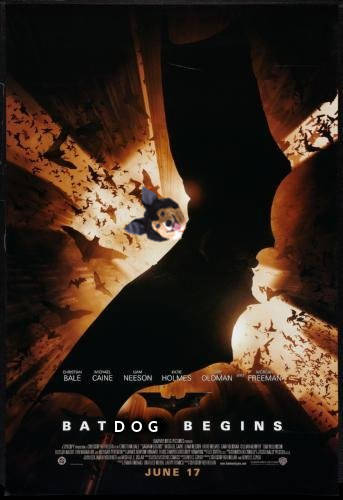

**A Python notebook for processing of parallaxes, comparison with variable star distances and inference of line of sight interstellar extinction to said variable stars.**

This notebook was developed with Table of Contents 2, a Jupyter notebook extension that makes navigating between sections of the code significantly easier. It is strongly recommended that you install this extension. Some details about how to do this can be found here: https://ndres.me/post/best-jupyter-notebook-extensions/ (remember to restart Jupyter after installing nbextensions)

------

<h1>Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports-and-dependencies" data-toc-modified-id="Imports-and-dependencies-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports and dependencies</a></span></li><li><span><a href="#Loading-of-artificial-data" data-toc-modified-id="Loading-of-artificial-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading of artificial data</a></span><ul class="toc-item"><li><span><a href="#Set-model-parameters" data-toc-modified-id="Set-model-parameters-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span><font color="red">Set model parameters</font></a></span></li><li><span><a href="#Define-PLR-relation-convenience-functions" data-toc-modified-id="Define-PLR-relation-convenience-functions-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Define PLR relation convenience functions</a></span></li><li><span><a href="#Setup-a-fake-distribution-of-stars" data-toc-modified-id="Setup-a-fake-distribution-of-stars-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Setup a fake distribution of stars</a></span></li><li><span><a href="#Set-the-numpy-random-seed" data-toc-modified-id="Set-the-numpy-random-seed-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Set the numpy random seed</a></span></li><li><span><a href="#Setup-of-the-stars-to-infer-dust-to" data-toc-modified-id="Setup-of-the-stars-to-infer-dust-to-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Setup of the stars to infer dust to</a></span><ul class="toc-item"><li><span><a href="#Sample-some-fake-variable-stars-from-the-stellar-distribution" data-toc-modified-id="Sample-some-fake-variable-stars-from-the-stellar-distribution-2.5.1"><span class="toc-item-num">2.5.1&nbsp;&nbsp;</span>Sample some fake variable stars from the stellar distribution</a></span></li><li><span><a href="#Model-experimental-parameters-for-the-fake-stars" data-toc-modified-id="Model-experimental-parameters-for-the-fake-stars-2.5.2"><span class="toc-item-num">2.5.2&nbsp;&nbsp;</span>Model experimental parameters for the fake stars</a></span></li></ul></li><li><span><a href="#Magellanic-Cloud---setup-of-the-prior-stars" data-toc-modified-id="Magellanic-Cloud---setup-of-the-prior-stars-2.6"><span class="toc-item-num">2.6&nbsp;&nbsp;</span>Magellanic Cloud - setup of the prior stars</a></span><ul class="toc-item"><li><span><a href="#Sample-some-fake-stars" data-toc-modified-id="Sample-some-fake-stars-2.6.1"><span class="toc-item-num">2.6.1&nbsp;&nbsp;</span>Sample some fake stars</a></span></li><li><span><a href="#Define-a-ParallaxPrior-class" data-toc-modified-id="Define-a-ParallaxPrior-class-2.6.2"><span class="toc-item-num">2.6.2&nbsp;&nbsp;</span>Define a ParallaxPrior class</a></span></li><li><span><a href="#Initialise-the-ParallaxPrior-class" data-toc-modified-id="Initialise-the-ParallaxPrior-class-2.6.3"><span class="toc-item-num">2.6.3&nbsp;&nbsp;</span>Initialise the ParallaxPrior class</a></span></li></ul></li><li><span><a href="#Setup-of-omega_0-constraining-binary-stars" data-toc-modified-id="Setup-of-omega_0-constraining-binary-stars-2.7"><span class="toc-item-num">2.7&nbsp;&nbsp;</span>Setup of omega_0 constraining binary stars</a></span></li></ul></li><li><span><a href="#Setup-of-likelihood-&amp;-priors" data-toc-modified-id="Setup-of-likelihood-&amp;-priors-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Setup of likelihood &amp; priors</a></span><ul class="toc-item"><li><span><a href="#A-debug-helper-function" data-toc-modified-id="A-debug-helper-function-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>A debug helper function</a></span></li><li><span><a href="#Priors" data-toc-modified-id="Priors-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Priors</a></span><ul class="toc-item"><li><span><a href="#Prior-on-extinction" data-toc-modified-id="Prior-on-extinction-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Prior on extinction</a></span></li><li><span><a href="#Prior-on-PLR-parameters" data-toc-modified-id="Prior-on-PLR-parameters-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Prior on PLR parameters</a></span></li><li><span><a href="#Parallax-priors" data-toc-modified-id="Parallax-priors-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Parallax priors</a></span><ul class="toc-item"><li><span><a href="#Prior-on-variable-star-parallax" data-toc-modified-id="Prior-on-variable-star-parallax-3.2.3.1"><span class="toc-item-num">3.2.3.1&nbsp;&nbsp;</span>Prior on variable star parallax</a></span></li><li><span><a href="#Prior-on-binary-star-parallax" data-toc-modified-id="Prior-on-binary-star-parallax-3.2.3.2"><span class="toc-item-num">3.2.3.2&nbsp;&nbsp;</span>Prior on binary star parallax</a></span></li><li><span><a href="#Prior-on-parallax-offset" data-toc-modified-id="Prior-on-parallax-offset-3.2.3.3"><span class="toc-item-num">3.2.3.3&nbsp;&nbsp;</span>Prior on parallax offset</a></span></li></ul></li><li><span><a href="#Prior-on-scale-length" data-toc-modified-id="Prior-on-scale-length-3.2.4"><span class="toc-item-num">3.2.4&nbsp;&nbsp;</span>Prior on scale length</a></span></li><li><span><a href="#Logarithmic-priors-combination" data-toc-modified-id="Logarithmic-priors-combination-3.2.5"><span class="toc-item-num">3.2.5&nbsp;&nbsp;</span>Logarithmic priors combination</a></span></li></ul></li><li><span><a href="#Likelihood-function" data-toc-modified-id="Likelihood-function-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Likelihood function</a></span><ul class="toc-item"><li><span><a href="#Parallax-likelihoods" data-toc-modified-id="Parallax-likelihoods-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Parallax likelihoods</a></span><ul class="toc-item"><li><span><a href="#For-variable-stars" data-toc-modified-id="For-variable-stars-3.3.1.1"><span class="toc-item-num">3.3.1.1&nbsp;&nbsp;</span>For variable stars</a></span></li><li><span><a href="#For-binary-stars---Gaia-measurements" data-toc-modified-id="For-binary-stars---Gaia-measurements-3.3.1.2"><span class="toc-item-num">3.3.1.2&nbsp;&nbsp;</span>For binary stars - Gaia measurements</a></span></li><li><span><a href="#For-binary-stars---external-measurements" data-toc-modified-id="For-binary-stars---external-measurements-3.3.1.3"><span class="toc-item-num">3.3.1.3&nbsp;&nbsp;</span>For binary stars - external measurements</a></span></li></ul></li><li><span><a href="#Likelihood-of-period-data" data-toc-modified-id="Likelihood-of-period-data-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Likelihood of period data</a></span></li><li><span><a href="#Likelihood-of-apparent-magnitude-data" data-toc-modified-id="Likelihood-of-apparent-magnitude-data-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Likelihood of apparent magnitude data</a></span></li><li><span><a href="#Probability-of-the-nuisance-magnitude-parameters" data-toc-modified-id="Probability-of-the-nuisance-magnitude-parameters-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Probability of the nuisance magnitude parameters</a></span></li><li><span><a href="#Logarithmic-likelihoods-combination" data-toc-modified-id="Logarithmic-likelihoods-combination-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Logarithmic likelihoods combination</a></span></li></ul></li><li><span><a href="#Posterior" data-toc-modified-id="Posterior-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Posterior</a></span></li></ul></li><li><span><a href="#Creation-of-a-starting-guess" data-toc-modified-id="Creation-of-a-starting-guess-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Creation of a starting guess</a></span><ul class="toc-item"><li><span><a href="#Define-a-function-that-sets-up-a-ranges-dictionary" data-toc-modified-id="Define-a-function-that-sets-up-a-ranges-dictionary-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Define a function that sets up a <em>ranges</em> dictionary</a></span></li><li><span><a href="#Make-a-dictionary-of-data" data-toc-modified-id="Make-a-dictionary-of-data-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Make a dictionary of data</a></span></li><li><span><a href="#Set-initial-expected-hyperparameter-guesses" data-toc-modified-id="Set-initial-expected-hyperparameter-guesses-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Set initial expected hyperparameter guesses</a></span></li><li><span><a href="#Create-a-starting-guess-parameters-vector" data-toc-modified-id="Create-a-starting-guess-parameters-vector-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Create a starting guess parameters vector</a></span></li><li><span><a href="#Maximise-said-starting-guess-in-a-rigorous-process" data-toc-modified-id="Maximise-said-starting-guess-in-a-rigorous-process-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Maximise said starting guess in a rigorous process</a></span><ul class="toc-item"><li><span><a href="#Find-omega_0-from-assumed-correct-omega_B-values" data-toc-modified-id="Find-omega_0-from-assumed-correct-omega_B-values-4.5.1"><span class="toc-item-num">4.5.1&nbsp;&nbsp;</span>Find omega_0 from assumed-correct omega_B values</a></span></li><li><span><a href="#Parallax-maximisation" data-toc-modified-id="Parallax-maximisation-4.5.2"><span class="toc-item-num">4.5.2&nbsp;&nbsp;</span>Parallax maximisation</a></span></li><li><span><a href="#Inference-of-extinctions-from-parallax-guesses" data-toc-modified-id="Inference-of-extinctions-from-parallax-guesses-4.5.3"><span class="toc-item-num">4.5.3&nbsp;&nbsp;</span>Inference of extinctions from parallax guesses</a></span></li></ul></li><li><span><a href="#Export-the-starting-guesses-into-a-(checked)-set-of-dimensions-guesses" data-toc-modified-id="Export-the-starting-guesses-into-a-(checked)-set-of-dimensions-guesses-4.6"><span class="toc-item-num">4.6&nbsp;&nbsp;</span>Export the starting guesses into a (checked) set of <em>dimensions</em> guesses</a></span></li></ul></li><li><span><a href="#Running-of-emcee" data-toc-modified-id="Running-of-emcee-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Running of emcee</a></span><ul class="toc-item"><li><span><a href="#Define-an-emcee-running-function" data-toc-modified-id="Define-an-emcee-running-function-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Define an emcee running function</a></span></li><li><span><a href="#Define-plotting-functions" data-toc-modified-id="Define-plotting-functions-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Define plotting functions</a></span></li><li><span><a href="#Initialise-emcee-and-try-a-few-first-steps" data-toc-modified-id="Initialise-emcee-and-try-a-few-first-steps-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Initialise emcee and try a few first steps</a></span></li><li><span><a href="#Run-emcee-for-reals-and-check-output" data-toc-modified-id="Run-emcee-for-reals-and-check-output-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Run emcee <em>for reals</em> and check output</a></span></li></ul></li><li><span><a href="#Data-saving-and-plotting" data-toc-modified-id="Data-saving-and-plotting-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Data saving and plotting</a></span><ul class="toc-item"><li><span><a href="#Function-for-computing-sample-quantiles" data-toc-modified-id="Function-for-computing-sample-quantiles-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Function for computing sample quantiles</a></span></li><li><span><a href="#Compare-between-true-&amp;-inferred-values" data-toc-modified-id="Compare-between-true-&amp;-inferred-values-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Compare between true &amp; inferred values</a></span></li></ul></li><li><span><a href="#Deprecated-code" data-toc-modified-id="Deprecated-code-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Deprecated code</a></span><ul class="toc-item"><li><span><a href="#Some-testing-of-s-parameter-space" data-toc-modified-id="Some-testing-of-s-parameter-space-7.1"><span class="toc-item-num">7.1&nbsp;&nbsp;</span>Some testing of <em>s</em> parameter space</a></span></li><li><span><a href="#Some-testing-of-A-parameter-space" data-toc-modified-id="Some-testing-of-A-parameter-space-7.2"><span class="toc-item-num">7.2&nbsp;&nbsp;</span>Some testing of <em>A</em> parameter space</a></span></li><li><span><a href="#From-the-maximisation-function" data-toc-modified-id="From-the-maximisation-function-7.3"><span class="toc-item-num">7.3&nbsp;&nbsp;</span>From the maximisation function</a></span></li><li><span><a href="#More-from-the-maximisation-function-(how-it-was-at-the-start-of-batdog_begins)" data-toc-modified-id="More-from-the-maximisation-function-(how-it-was-at-the-start-of-batdog_begins)-7.4"><span class="toc-item-num">7.4&nbsp;&nbsp;</span>More from the maximisation function (how it was at the start of batdog_begins)</a></span></li><li><span><a href="#Run-the-maximisation-function-for-all-stars" data-toc-modified-id="Run-the-maximisation-function-for-all-stars-7.5"><span class="toc-item-num">7.5&nbsp;&nbsp;</span>Run the maximisation function for all stars</a></span></li><li><span><a href="#Test-of-how-matrices-work-in-numpy" data-toc-modified-id="Test-of-how-matrices-work-in-numpy-7.6"><span class="toc-item-num">7.6&nbsp;&nbsp;</span>Test of how matrices work in numpy</a></span></li><li><span><a href="#Old-ranges-code" data-toc-modified-id="Old-ranges-code-7.7"><span class="toc-item-num">7.7&nbsp;&nbsp;</span>Old ranges code</a></span></li><li><span><a href="#Some-code-for-a-different-parallax-prior-using-stars-as-Gaussians,-not-points" data-toc-modified-id="Some-code-for-a-different-parallax-prior-using-stars-as-Gaussians,-not-points-7.8"><span class="toc-item-num">7.8&nbsp;&nbsp;</span>Some code for a different parallax prior using stars as Gaussians, not points</a></span></li><li><span><a href="#Let's-import-some-data" data-toc-modified-id="Let's-import-some-data-7.9"><span class="toc-item-num">7.9&nbsp;&nbsp;</span>Let's import some data</a></span><ul class="toc-item"><li><span><a href="#OGLE" data-toc-modified-id="OGLE-7.9.1"><span class="toc-item-num">7.9.1&nbsp;&nbsp;</span>OGLE</a></span></li><li><span><a href="#VMC" data-toc-modified-id="VMC-7.9.2"><span class="toc-item-num">7.9.2&nbsp;&nbsp;</span>VMC</a></span></li></ul></li></ul></li></ul></div>

## A note on units<span class="tocSkip"></span>
Throughout this notebook, the following unit conventions are always used:
* Distance: expressed in **pc** (or **kpc** when clearly stated)
* Parallaxes: always in **mas**.
* Angles: always converted into **radians**, for better numpy compatibility.
---

# Imports and dependencies
------

Specify directories

In [177]:
# Directory where we can find data for plotting
data_dir = 'data/'

Import packages

In [178]:
import numpy as np
import pandas as pd
import sys
import time
import matplotlib.pyplot as plt
import emcee  # MCMC package
import corner  # For plots later - not essential to run but great for viewing
from psutil import virtual_memory  # For preventing RAM errors in emcee running
from mpl_toolkits.mplot3d import Axes3D  # 3D plots
from astropy.stats import knuth_bin_width  # Great bin width estimator
from scipy.optimize import minimize  # Used in a few places for minimisation
from scipy.stats import norm  # Fast normal distribution evaluator
from scipy.stats import iqr as interquartile_range
from scipy.signal import savgol_filter  # Smoothing algorithm
from scipy.interpolate import interp1d as interpolate  # Cubic splines

# Loading of artificial data
------

## <font color=red>Set model parameters</font>
Here, we input parameters for the artificial stellar distribution. To change the shape of the distribution you'll need to dive into the code - but important stuff lives here at the top.

In [179]:
# Set some parameters
number_of_cores = 8  # Number of CPU cores to use
N_stars = 100  # Number of stars
N_binaries = 0  # If zero, binary stars will be excluded from the model.
scale_true = 50000  # Mean distance to stars

# Set the type of parallax prior:
# finite_cloud, decreasing_space_density
prior_type = 'finite_cloud'
N_prior = 2000  # Necessary for 'finite cloud' data


## Define PLR relation convenience functions
We define a PLR relation class with a number of useful methods. Each instance stores its own PLR parameters.

In [180]:
def PLR_magnitude(a, b, P):
    """Returns the result of the metallacity-independent Leavitt Law given a 
    period.
    """
    return a * np.log10(P) + b


def PLR_period(a, b, m):
    """Returns the result of the metallacity-independent Leavitt Law given a 
    magnitude.
    """
    return np.power(10, (m-b)/a)

## Setup a fake distribution of stars
Here we create a fake distribution and check it looks about like what we want. It's not exactly a Gaussian because I don't want to make the priors' life easy. That would be, like, boring.

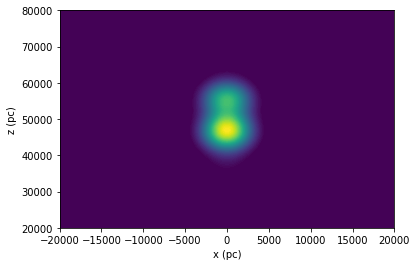

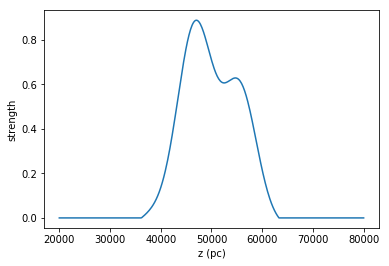

In [181]:
def stellar_distribution(x, y, z):
    """Accepts input in pc only."""
    # Convert into kpc
    x = np.divide(x, 1000)
    y = np.divide(y, 1000)
    z = np.divide(z, 1000)   
    
    # Constants - change me!
    period = 60  # period of cosin oscillations 
    sigma = 2  # sd of Gaussian
    s = [1, 1.5, 0.1]  # array of scale factors
    l = [0, 0, 50]  # array of offsets
    A = 0.6  # strength of cos fn
    B = 1  # offset of cos fn
    myNorm = 0.011  # empirical constant to put the maximum value at 1
    fuckFactor = 0.59  # power on the cosine. absolute madness entails!!1!
    
    # Internal pre-calculated constants for readability - don't change me!
    omega = 2*np.pi / period  # anguluar freq of cosine
    c1 = 1 / ((2 * np.pi)**(3./2.) * sigma**3)  # first constant in Gaussian
    c2 = -1 / (2 * sigma**2)  # second constant in Gaussian
    power = c2 * (s[0]*(x - l[0])**2 + s[1]*(y-l[1])**2 + s[2]*(z-l[2])**2)  # power of Gaussian
    
    # Return the answer
    return np.clip(1/myNorm * ((A * np.cos((x**2 + y**2 + z**2)**(fuckFactor)*omega)**2 
                       + B) * c1 * np.exp(power))-0.08, 0.0, 1)

# Make a z-x heatmap
test_points = 400
xrange = np.linspace(-20000, 20000, num=test_points)
yrange = np.linspace(-20000, 20000, num=test_points)
zrange = np.linspace(20000, 80000, num=test_points)

xx, zz = np.meshgrid(xrange, zrange)

krange = stellar_distribution(xx, 0, zz)

plt.contourf(xx, zz, krange, 100)
plt.xlabel("x (pc)")
plt.ylabel("z (pc)")
plt.show()

# Make a z-axis only plot
plt.plot(zrange, stellar_distribution(0, 0, zrange))
plt.xlabel("z (pc)")
plt.ylabel("strength")
plt.show()

Let's also make a re-usable function that can sample stellar_distribution as much as required.

In [182]:
def sample_stellar_distribution(N):
    """Samples stellar_distribution N times and returns stars in ra, dec, r 
    form.
    """
    # Constants - set depending on distribution shape
    xy_min = -5000.0
    xy_max = 5000.0
    z_min = 35000.0
    z_max = 65000.0   
    
    # Internal variables
    ra = np.zeros(N)
    dec = np.zeros(N)
    r = np.zeros(N)
    i = 0
    while i < N:
        # Pick a random x, y, z co-ordinate
        test_x = (xy_max - xy_min)*np.random.rand() + xy_min
        test_y = (xy_max - xy_min)*np.random.rand() + xy_min
        test_z = (z_max - z_min)*np.random.rand() + z_min
        
        # Pick a uniform deviate between 0 and 1
        test_p = np.random.rand()
        
        # Only accept this star if test_p is less than the distribution
        if test_p < stellar_distribution(test_x, test_y, test_z):
            sys.stdout.write("\rDone {}".format(i))
            sys.stdout.flush()
            
            # Convert to ra, dec (note: NOT the same as sph. polars!!)
            r[i] = np.sqrt(test_x**2 + test_y**2 + test_z**2)         
            dec[i] = -np.arccos(test_z / r[i]) + np.pi/2
            ra[i] = np.arctan2(test_y, test_x) + np.pi/2
            
            # Do some checks on right ascension because it's an awkward cookie
            if ra[i] < 0:
                ra[i] += 2* np.pi
            elif ra[i] > 2*np.pi:
                ra[i] -= 2*np.pi
                       
            # Only move on if this all worked
            i += 1
    
    # Return ra, dec, r
    sys.stdout.write("\rAll done!     ")
    sys.stdout.flush()
    return [ra, dec, r]

## Set the numpy random seed
This is important, because this means that everything below will be the same when ran withthe same initial conditions.

In [183]:
np.random.seed(42)

## Setup of the stars to infer dust to

### Sample some fake variable stars from the stellar distribution

Let's sample the real location of the stars

In [184]:
# Some names for star samples, currently just consecutive integers
sampled_ids = pd.Series(list(range(0, N_stars)))

# A pandas DataFrame for all true and experimental data
data = pd.DataFrame(sampled_ids, columns=['ID'])

# Sample N_stars stars and save to our DataFrame
data['ra'], data['dec'], data['r_true'] = \
    sample_stellar_distribution(N_stars)
    
# Assign implied parallax values to the data frame
data['omega_true'] = pd.Series((1 / data['r_true'])*1e3)

All done!     

Let's assign stellar parameters from a PLR relation we're gonna make up for funsies.

In [185]:
band_names = ['E', 'M', 'I']
a_true = [-2.9, -2.8, -2.7]
b_true = [ -4.9,  -4.8,  -4.7]
s_true = [ 0.1,  0.3,  0.5]
N_bands = len(band_names)  # number of bands

Use the PL relation to infer values for things like magnitude.

In [186]:
# Calculate PLR parameters
# Periods between 5 to 20 days.
data['P_true'] = pd.Series((20-5)*np.random.rand(N_stars) + 5)

# Cycle over bands and make up absolute magnitudes, extinctions and app. magn.
for i, j in zip(band_names, range(N_bands)):
    band = '_true' + '_' + i
    
    # Calculate absolute magnitude from PLR and add disperion, std.d. of s_true
    data['s'+band] = np.random.normal(loc=0, scale=s_true[j], size=N_stars)
    data['M'+band] = (pd.Series(
                            PLR_magnitude(a_true[j], b_true[j], data['P_true'])
                            + data['s'+band]))
    
    # Extinction is between (j)/nbands + 1.2 and 0.4.
    data['A'+band] = pd.Series((j/N_bands + 1.2 - 0.4)*np.random.rand(N_stars) + 0.4)
    data['m'+band] = (pd.Series(data['M'+band] + 5*np.log10(data['r_true']/10)) 
                      + data['A'+band])

### Model experimental parameters for the fake stars

Now, let's sample some experimental values by messing true values up with random and systematic errors.

In [187]:
def parallax_error_estimator(magnitude, N_stars):
    """Models parallax error according to Gaia collaboration 
    2018 - Summary of contents & survery properties
    - - - - - - - - - - 
     m   sigma_omega [mas]
    <15  0.02-0.04
     17  0.10
     20  0.70
     21  2.00
    """
    # Always 0.02 below 11
    magnitude = np.where(magnitude <= 11, 0.02, 
                         magnitude)
    
    # Make it big for over 21
    magnitude =  np.where(magnitude > 21, 2 * (magnitude-20), 
                          magnitude)
    
    # Linear between 0.7 at 20, 2.0 at 21
    magnitude = np.where(magnitude > 20, 1.3 * (magnitude-20) + 0.70, 
                         magnitude)
    
    # Linear between 0.1 at 17, 0.7 at 20
    magnitude = np.where(magnitude > 17, 0.20 * (magnitude-17) + 0.10, 
                         magnitude)
    
    # Linear between 0.04 at 15, 0.1 at 17
    magnitude = np.where(magnitude > 15, 0.03 * (magnitude-20) + 0.04, 
                         magnitude)
    
    # Linear between 0.02 at 11, 0.04 at 15
    magnitude = np.where(magnitude > 11, 0.005 * (magnitude-20) + 0.02, 
                         magnitude)
    
    # Add a bit of random error & return
    return magnitude * np.random.normal(loc=1, scale=0.2, size=N_stars)


"""Parallax"""
omega_0_true = -0.05  # in mas
parallax_errors = parallax_error_estimator(data['m_true_I'], N_stars) / 20  # BIG CHEEKY DIVISION HAPPENING
data['omega_exp'] = (data['omega_true'] + omega_0_true
                     + np.random.normal(loc=0, scale=1, size=N_stars) 
                     * parallax_errors)
data['omega_sigma'] = np.abs(parallax_errors)


"""Period"""
# Typical 1.5% P error
period_errors = data['P_true'] * np.random.normal(loc=0, scale=0.015, size=N_stars)
data['P_exp'] = data['P_true'] + period_errors
data['P_sigma'] = data['P_exp'] * 0.015


"""Apparent magnitude (uncorrected for extinction) & extinction estimates"""
# Typical errors from Scowcroft 2016 - typical 0.01 mag
# Cycle over all my bands
# Cycle over bands and make up absolute magnitudes, extinctions and app. magn.
for i, j in zip(band_names, range(N_bands)):
    band = '_' + i
    app_magnitude_errors = np.random.normal(loc=0, scale=0.01, size=N_stars)
    data['m_exp'+band] = data['m_true'+band] + app_magnitude_errors
    data['m_sigma'+band] = 0.01
    data['A_exp'+band] = data['A_true'+band] * ((0.9-0.5)*np.random.rand(N_stars) + 0.5)
    data['A_sigma'+band] = 0.3 * data['A_exp'+band]   # 30% error on all


"""Inferred absolute magniture from the test PLR"""
### THIS CURRENTLY JUST USES INPUT ERROR - needs knowledge of relationship error also
# We are assuming that the scatter is much greater than the period error
# to justify M being treated as a Gaussian deviate.
#data['M_exp'] = pd.Series(test_PLR.magnitude(data['P_exp']) + data['s_true'])
#data['M_sigma'] = pd.Series(np.sqrt(
#            (test_PLR.read_band_a() * data['P_sigma']/data['P_exp'] 
#             * np.log(data['P_exp']))**2 
#            + (0 * test_PLR.read_band_b())**2
#            + (0 * dispersion_guess)**2))

# """Inferred radii from the test PLR"""
# data['r_exp'] = np.power(10, (data['m_exp'] 
#                              - data['M_exp']) / 5 + 1)
# data['r_exp_u'] = np.power(10, (data['m_exp'] + data['m_sigma']
#                                - data['M_sigma']) / 5 + 1)
# data['r_exp_l'] = np.power(10, (data['m_exp'] - data['m_sigma']
#                                + data['M_sigma']) / 5 + 1)

# Output some data so far to look at what our results are like
data[['m_true'+band, 'omega_true', 'omega_exp', 'omega_sigma']]

,m_true_I,omega_true,omega_exp,omega_sigma
0,12.735534,0.020834,-0.031372,0.000751
1,11.162043,0.018493,-0.030274,0.001199
2,12.137607,0.021368,-0.027344,0.000753
3,12.646269,0.020824,-0.028728,0.001140
4,12.109443,0.021789,-0.026946,0.000807
5,11.846532,0.023847,-0.024811,0.000899
6,12.194860,0.021297,-0.027937,0.000765
7,12.866659,0.019289,-0.029729,0.001065
8,13.353588,0.021843,-0.027455,0.000735
9,11.230578,0.021048,-0.029454,0.000969


## Magellanic Cloud - setup of the prior stars

### Sample some fake stars

In [188]:
# Some names for star samples, currently just consecutive integers
sampled_ids = pd.Series(list(range(0, N_prior)))

# A pandas DataFrame for all prior data
data_prior = pd.DataFrame(sampled_ids, columns=['ID'])

# Sample N_prior stars and save to our DataFrame
data_prior['ra'], data_prior['dec'], data_prior['r_true'] = \
    sample_stellar_distribution(N_prior)
    
# Make up an error on r and pull the stars from said error
r_errors = (1000 - 500) * np.random.rand(N_prior) + 500
data_prior['r_exp'] = (data_prior['r_true'] 
    + np.random.normal(loc=0, scale=1, size=N_prior) * r_errors)
data_prior['r_sigma'] = r_errors

# Have a peek to make sure this worked
data_prior

All done!     

,ID,ra,dec,r_true,r_exp,r_sigma
0,0,1.332484,1.540451,49882.494750,50700.915639,573.488598
1,1,4.913156,1.536351,45050.815436,45912.085582,905.257034
2,2,1.985730,1.534907,60022.022648,59885.983811,802.378941
3,3,1.747373,1.529049,46415.266415,46395.264527,559.724001
4,4,3.363459,1.527287,46682.745631,45959.352680,958.768920
5,5,0.043193,1.536731,50278.519968,49543.591761,811.313230
6,6,1.972510,1.522704,55655.346642,55214.661796,586.168199
7,7,3.860006,1.537455,45982.882079,45857.713079,612.090911
8,8,4.633852,1.520815,42954.549630,43021.852346,602.069694
9,9,2.397945,1.540385,50980.893294,50809.692912,612.651194


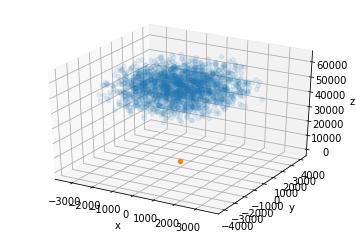

In [189]:
# A plot of the prior
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_prior['r_exp']*np.cos(data_prior['dec'])*np.cos(data_prior['ra']), 
           data_prior['r_exp']*np.cos(data_prior['dec'])*np.sin(data_prior['ra']), 
           data_prior['r_exp']*np.sin(data_prior['dec']), 'bo', alpha=0.1)
ax.scatter([0],[0],[0], 'ro')  # Gaia!

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
plt.show()

### Define a ParallaxPrior class

In [190]:
class ParallaxPrior:
    """The following class should be created for each type of prior. It stores 
    information about the stars' prior on parallax, which is dependent on its
    right ascension and declination in 3D space.
    
    The class was coded with a philosophy of having lots of values kept in
    class-wide dictionaries. This means that they can easily be accessed and
    checked.
    
    N.B. All inbound angles must be in radians. 
    """
    
    def __init__(self, ra=0, dec=0, r=0, r_sigma=0, prior_type='finite_cloud'):
        """Initialisation of the class. Makes some local copies of things
        we'll be needing for the duration of our stay.
        """         
        # A boolean to record whether the user changed boundary behaviour
        self.set_boundaries_to_zero = True
        
        # Set the type of prior            
        if prior_type == 'finite_cloud':
            self.prior_mode = prior_type
            
            # Keep a local copy of the locations of stars to consider for priors,
            # converted into cartesians to make later maths easier
            self.distribution = np.zeros((ra.size, 3))
            self.distribution_r = np.asarray(r.copy())
            self.distribution_sigma = np.asarray(r_sigma.copy())

            # Calc x, y, z
            self.distribution[:, 0] = np.cos(dec) * np.cos(ra)
            self.distribution[:, 1] = np.cos(dec) * np.sin(ra)
            self.distribution[:, 2] = np.sin(dec)

            # Initialise class-wide copies of histogram information
            self.bin_widths = {}
            self.bin_numbers = {}
            self.bin_centres = {}
            self.prior_histograms = {}
            self.filtered_histograms = {}
            self.fits = {}
            self.fast_access_fits = np.zeros(1)
            
            # Set evaluate_multiple_priors to the right thing:
            self.evaluate_multiple_priors = \
                self.evaluate_multiple_priors_finite_cloud
            
        elif prior_type == 'decreasing_space_density':
            self.prior_mode = prior_type
            # Just set the prior evaluation function to use a decreasing volume
            # density
            self.evaluate_multiple_priors = \
                self.evaluate_multiple_priors_decreasing_space_density
                
        else:
            raise TypeError('specified prior_type not supported.')
            
    def make_histograms(self, ID, ra, dec, beam_width, 
                        user_set_boundaries_to_zero=True, boundary_points=5):
        """Uses a Gaussian beam to sample histograms from stellar_distribution 
        and saves the results of these histograms.
        """
        # Quit if this function isn't actually needed. We raise an error, 
        # because it shouldn't be getting called.
        if self.prior_mode != 'finite_cloud':
            raise TypeError('only the finite_cloud prior_type is currently supported by plot_priors.')
        
        # Record the users' boundary preferences in the class-wide boolean
        self.set_boundaries_to_zero = user_set_boundaries_to_zero
        
        # Firstly, we create an array of beam unit vectors in Cartesians.
        # Later vector maths is much easier in arbitraty Cartesians centred on
        # Gaia, so we make the change now so my head hurts less later :)
        test_stars = np.zeros((ID.size, 3))
        test_stars[:, 0] = np.cos(dec) * np.cos(ra)
        test_stars[:, 1] = np.cos(dec) * np.sin(ra)
        test_stars[:, 2] = np.sin(dec)
        
        # Calculate angles between test stars and the distribution with a fancy
        # formula from: https://stackoverflow.com/questions/2827393/angles-between-two-n-dimensional-vectors-in-python/13849249#13849249
        # This is done with a fast matrix method too because BATDOG is too cool
        # for for loops
        angles_between = np.arccos(np.clip(test_stars @ self.distribution.T, 
                                           -1.0, 1.0))
        
        # Calculate the distance from and along the beam of each star, and use 
        # this to compute a weight value for the star from a Gaussian of 
        # standard deviation beam_width
        distances_from_beam = self.distribution_r * np.sin(angles_between)
        distances_along_beam = self.distribution_r * np.cos(angles_between)
        star_weights = norm(0, beam_width).pdf(distances_from_beam)
        
        # Loop over all the test stars and make some absolutely-sick-stograms.
        # Unfortunately, this has to be done with a for loop, since astropy's 
        # Knuth rule and numpy's histogram methods both only take 1D data. 
        # Also, it's quite naughty to use Knuth's rule on a weighted histogram. 
        # However, I couldn't find a bin rule for weighted histograms, and it 
        # comes up with the best guesses anyway regardless of the weighting.
        i = 0
        for test_star, an_ID in zip(distances_along_beam, ID):
            # Calculate optimal bin widths using Knuth's rule
            self.bin_widths[an_ID] = knuth_bin_width(test_star)

            # Convert said bin width into a number of bins
            self.bin_numbers[an_ID] = int(((test_star.max() - test_star.min()) 
                                       / self.bin_widths[an_ID]))

            # Calculate the resulting prior histogram for this 
            self.prior_histograms[an_ID], bin_edges = np.histogram(
                                                test_star, 
                                                bins=self.bin_numbers[an_ID], 
                                                weights=star_weights[i])
            
            # Set the boundaries of the histogram to zero. This is... 
            # *technically* extrapolation, but... it's also, like, necessary.
            # We do this for boundary_points points opposed to just one,
            # because a well-defined and long boundary behaves better with the
            # filtering methods.
            if self.set_boundaries_to_zero:
                # Boundary_array forces the inserted/appended values to be an
                # array of length boundary_points, giving us our desired number
                # of zero points.
                boundary_array = np.arange(1, boundary_points + 1)
                bin_edges = np.append(
                    np.insert(bin_edges, 0, 
                        bin_edges[0] - boundary_array*self.bin_widths[an_ID]),
                    bin_edges[-1] + boundary_array * self.bin_widths[an_ID])
                
                self.prior_histograms[an_ID] = np.append(
                    np.insert(
                        self.prior_histograms[an_ID], 0, 0.0 * boundary_array), 
                    0.0 * boundary_array)
                self.bin_numbers[an_ID] += boundary_points * 2
            
            # Convert bin edges (meh) into bin centres (yassss!) by finding the
            # mean value between each point with a clever array thing that I'm
            # actually proud of thinking of yay
            self.bin_centres[an_ID] = (bin_edges[1:] + bin_edges[:-1]) / 2
            i += 1
        
    def fit_priors(self, ID, filter_window_size=5, filter_polynomial_order=3,
                  fit_type='slinear'):
        """Fits cubic splines to a filtered version of the histogram data.
        We filter using a Savitzky-Golay filter, which helps to smooth out 
        input data. Then, interpolation is performed by 
        """
        # Quit if this function isn't actually needed. We raise an error, 
        # because it shouldn't be getting called.
        if self.prior_mode != 'finite_cloud':
            raise TypeError('only the finite_cloud prior_type is currently supported by plot_priors.')
            
        # Apply filters and interpolate a fit
        for an_ID in ID:
            # Calculation of derivatives (the deriv kwarg) at points causes mad 
            # fuckery (it makes things WORSE) so don't do it
            self.filtered_histograms[an_ID] = savgol_filter(
                                                self.prior_histograms[an_ID], 
                                                filter_window_size, 
                                                filter_polynomial_order, 
                                                deriv=0)
            
            # Check that none of the filter results are negative (the Savgol
            # filter knows not of probability being +ve only.) We also make 
            # sure the boundaries are still zero.
            self.filtered_histograms[an_ID][0] = 0.0
            self.filtered_histograms[an_ID][-1] = 0.0
            self.filtered_histograms[an_ID] = np.where(
                                self.filtered_histograms[an_ID] < 0, 
                                0.0, self.filtered_histograms[an_ID])
            
            # Use scipy's cubic interpolation to create a cubic fit function
            # for every star. Note that this fit is done in parallax space
            # (hence the one over), NOT r-space! This makes calls to these
            # functions faster as there aren't any conversions.
            self.fits[an_ID] = interpolate(1 / self.bin_centres[an_ID] * 1e3, 
                                           self.filtered_histograms[an_ID], 
                                           kind=fit_type,
                                           bounds_error=False,
                                           fill_value=0.0)
            
    def plot_priors(self, ID, r_min=30000, r_max=70000, 
                    true_distribution=False, ra=0, dec=0, test_points=100):
        """Plots the histograms for a set of *ID* histograms. Can also be
        plotted against a true distribution by specifying the location of
        the function with true_distribution.
        """
        # Quit if this function isn't actually needed. We raise an error, 
        # because it shouldn't be getting called.
        if self.prior_mode != 'finite_cloud':
            raise TypeError('only the finite_cloud prior_type is currently supported by plot_priors.')
        
        # Range of r values to plot over
        r_range = np.linspace(r_min, r_max, num=test_points)
        
        # Loop over all the stars
        for an_ID, array_index in zip(ID, range(ID.size)):
            plt.figure(figsize=(8, 6))           
            # The prior histogram values
            plt.plot(self.bin_centres[an_ID], self.prior_histograms[an_ID], 
                     'k--', lw=1, label='Prior')
            
            # The filtered prior
            plt.plot(self.bin_centres[an_ID], self.filtered_histograms[an_ID], 
                     'g--', lw=1, label='Filtered prior')
            
            # The spline fit to the filtered data
            # Get values of the spline. This is done in a for loop call so that
            # any errors arising from invalid input parallaxes can be caught.
            fit_results = np.zeros(test_points)
            for a_point in range(test_points):
                fit_results[a_point] = self.evaluate_a_single_prior(
                                            an_ID, 1 / r_range[a_point] * 1e3)
                
            plt.plot(r_range, fit_results, 'b-', lw=1, ms=0, 
                     label='Spline fit to filtered data')
            
            # Plot the real distribution if requested
            if true_distribution != False:
                # Work out Cartesian unit vectors for each star
                u_x = np.cos(dec[array_index]) * np.cos(ra[array_index])
                u_y = np.cos(dec[array_index]) * np.sin(ra[array_index])
                u_z = np.sin(dec[array_index])
                
                # Work out appropriate x, y, z ranges for the star
                x_range = np.linspace(r_min*u_x, r_max*u_x, num=test_points)
                y_range = np.linspace(r_min*u_y, r_max*u_y, num=test_points)
                z_range = np.linspace(r_min*u_z, r_max*u_z, num=test_points)
                
                # Plot the true distribution on the figure
                dist_to_plot = true_distribution(x_range, y_range, z_range)
                normalisation_factor = (self.prior_histograms[an_ID].max() 
                                        / dist_to_plot.max())
                plt.plot(r_range, dist_to_plot * normalisation_factor, 
                         'r-', lw=1, label='True distribution')
            
            # Final bits of plot formatting
            plt.legend()
            # plt.ylim(0, kDist.max()*1.1)
            plt.xlim(r_min,r_max)
            plt.ylabel('Probability')
            plt.xlabel('Distance (pc)')
            
            plt.title('Parallax prior (in distance space) for star {}'
                      .format(an_ID))
            plt.show()
        
        # Show everything at once at the end
        #plt.show()
    
    def evaluate_a_single_prior(self, an_ID, a_parallax, scale=False):
        """Evaluates a single prior at a single location for star ID. This 
        method is inherently slower than evaluate_multiple_priors.
        """
        if self.prior_mode == 'finite_cloud':
            # Work out the fit and return zero if we accidentally hit a -ve val
            result = self.fits[an_ID](a_parallax)
            if result < 0.0:
                result = 0.0
            return result
        
        elif self.prior_type == 'decreasing_space_density':
            # Return exponent of the log decreasing space density prior
            return np.exp(self.evaluate_multiple_priors(a_parallax, scale))
        
        else:
            raise TypeError('current prior_type is not supported by evaluate_a_single_prior.')
        
        
    def prep_for_fast_running(self, ID):
        """Must be called before evaluate_multiple_priors. Selects only desired 
        IDs and sets their fit functions up in a fast framework that can be 
        called during emcee running quickly and efficiently.
        """
        # Quit if this function isn't actually needed. However, we keep it
        # callable regardless of prior type as it's in a lot of places around
        # the code.
        if self.prior_mode != 'finite_cloud':
            return 0
        
        # Cast ID as a single-element array if it's a float
        ID = np.asarray(ID)
        
        # Create an empty numpy array that stores object pointers to each fit 
        # function
        self.fast_access_fits = np.empty(ID.size, dtype=object)
        
        # Loop over the dictionary (has to be done with a for loop sadly) and
        # pop required fit functions into fast_access_fits
        for an_ID, i in zip(ID, range(ID.size)):
            self.fast_access_fits[i] = self.fits[an_ID]
            
    def evaluate_multiple_priors_finite_cloud(self, test_omegas):
        """Fast evaluation of fit functions at all successful points. Must be
        called with input parallaxes of the correct shape. 
        
        NOTE 1: checking for negative probabilities implied by fits *is not 
        performed by this function*, and should instead be done on returned 
        data.
        
        NOTE 2: hence, logs must also be taken after data is returned.
        """
        # Use numpy vectorize to make a callable fector that takes a function
        # object and a function argument as inputs, and returns the result of 
        # the function call.
        function_vector = np.vectorize(lambda f, x: f(x))
        return function_vector(self.fast_access_fits, test_omegas)
    
    def evaluate_multiple_priors_decreasing_space_density(self, test_omegas, 
                                                      scale):
        """Returns evaluations of Bailer-Jones IV (2018) specified Milky-Way 
        prior.
        
        NOTE: logs happen in the function, as this makes function evaluation
        simpler (it would be pointless to raise things to an exponent only to
        take a log of them again.)
        """
        return np.where(params[r['omega']] < 0, -np.inf, 
                      np.log(1/(2 * params[r['L']]**3 * params[r['omega']]**2))
                      - 1 / (params[r['omega']] * params[r['L']]))

### Initialise the ParallaxPrior class

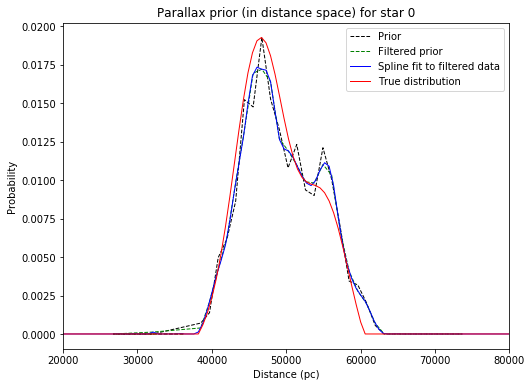

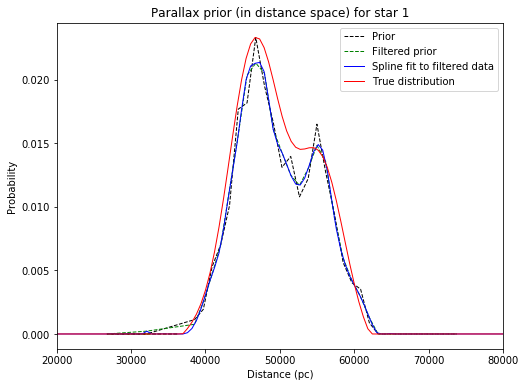

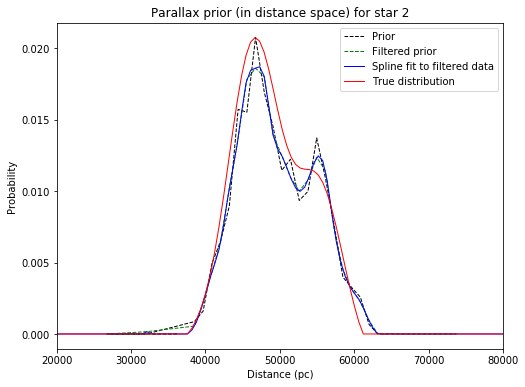

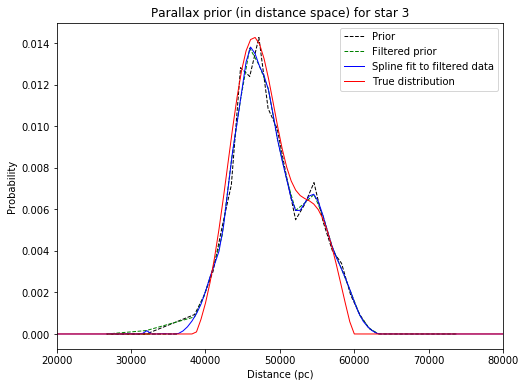

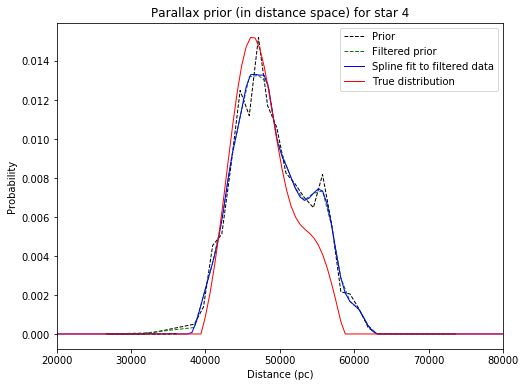

In [191]:
# Pass it everything it needs from data_prior
parallax_prior_repo = ParallaxPrior(ra=data_prior['ra'], 
                                    dec=data_prior['dec'], 
                                    r=data_prior['r_exp'], 
                                    r_sigma=data_prior['r_sigma'], 
                                    prior_type='finite_cloud')

# Create the finite_cloud histograms
parallax_prior_repo.make_histograms(data['ID'], data['ra'], data['dec'], 
                               1500, boundary_points=10)

# Smooth and make fit functions of said histograms
parallax_prior_repo.fit_priors(data['ID'], filter_window_size=5, 
                          filter_polynomial_order=3, fit_type='cubic')

# Plot 5 of these histograms so we can have a peek
test_IDs = np.arange(0, 5, dtype=np.int64)
parallax_prior_repo.plot_priors(test_IDs, 
                                true_distribution=stellar_distribution, 
                                ra=data['ra'], dec=data['dec'], 
                                test_points=100,
                                r_min=20000, r_max=80000)

In [192]:
# Rig the code for fast running if everything is ok =)
parallax_prior_repo.prep_for_fast_running(data['ID'])

## Setup of omega_0 constraining binary stars

In addition, we'll use some binary stars to constrain omega_0.

In [193]:
# Name the binaries and again create a data frame
sampled_ids = pd.Series(np.arange(0, N_binaries))
binaries = pd.DataFrame(sampled_ids, columns=['ID'])

# Assign a random ra and dec to every star
binaries['ra'] = pd.Series(np.random.rand(N_binaries) * 360)
binaries['dec'] = pd.Series((np.random.rand(N_binaries) - 0.5)*180)

# Repeat above and pull out some star locations from stellar_distribution
i = 0
r_true = np.zeros(N_binaries)
while i < N_binaries:
    # Create a test r of size 13 times that of the scale and a deviate test_p 
    # to compare with the interval
    test_r = (2*scale - scale/2)*np.random.rand() + scale/2
    test_p = np.random.rand()
    
    # See if the test point is in the distribution or not
    if test_p < stellar_distribution(test_r, scale, fact=factor):
        r_true[i] = test_r
        i += 1

# Assign r and implied parallax values we've got to the data frame
binaries['r_true'] = pd.Series(r_true)
binaries['omega_true'] = pd.Series((1 / r_true)*1e3)

# Assign an experimental parallax and error
parallax_errors = parallax_error_estimator(13, N_binaries)
binaries['gaia_exp'] = (binaries['omega_true'] + omega_0_true
                     + np.random.normal(loc=0, scale=1, size=N_binaries) 
                     * parallax_errors)
binaries['gaia_sigma'] = np.abs(parallax_errors)

# Same again, but for very precise external parallaxes
parallax_errors = np.random.normal(loc=0, scale=0.0001, size=N_binaries)
binaries['ext_exp'] = (binaries['omega_true'] * (1 + parallax_errors))
binaries['ext_sigma'] = np.sqrt(np.abs(parallax_errors)**2 
                                + 0.0001*binaries['ext_exp']**2)

# Output data for a peek
binaries

,ID,ra,dec,r_true,omega_true,gaia_exp,gaia_sigma,ext_exp,ext_sigma


# Setup of likelihood & priors
------

* **Note 1: everything here returns the result of a log, as emcee works in lnprob space.**
* **Note 2: conventionally, 'r' is used to specify the 'ranges' dictionary here as a convenient shorthand, since it appears absolutely everywhere.**

## A debug helper function
This function is a convenience to make debug error reporting in the following functions easier.

In [194]:
def debug_output(answer, fname, extra=""):
    """Checks an input array for non-finite values, and outputs the array,
    the name of the function and additional information if there are any.
    """
    # Check for infs and say where they are if so
    if np.all(np.isfinite(answer)) == False:
        print(fname + " encountered infs in these return array values:")
        print(np.where(np.isfinite(answer) == False)[0])
        
        # Print any extra information from the caller
        if len(extra) > 0:
            print("  " + extra)

## Priors
### Prior on extinction
This is simply a uniform prior to constrain the extinction co-efficient to something reasonable.

In [195]:
def prior_extinction(params, r, debug):
    """Currently, a uniform prior between a reasonable range for an 
    extinction co-efficient."""
    # Constants
    max_extinction = 5.0
    min_extinction = 0.0
    
    # Set any incorrect range extinctions to -np.inf (log of 0) and return A
    answer = np.where(np.logical_or(params[r['A']] < min_extinction, 
                                    params[r['A']] > max_extinction), 
                      -np.inf, 0)
    
    if debug:
        debug_output(answer, "prior_extinction")
    
    return answer

### Prior on PLR parameters
Basic uniform priors for a, b and a Jeffreys log-uniform prior on the scatter.

In [228]:
def prior_PLR(params, r, debug):
    """Uniform prior in reasonable ranges for a, b, and a Jeffreys log-uniform 
    prior for scatter.
    """
    # Constants
    max_a = 0.0
    min_a = -5.0
    max_b = 15.0
    min_b = -15.0
    
    # Tests
    a_prior = np.where(np.logical_or(params[r['a']] < min_a, 
                                    params[r['a']] > max_a), 
                      -np.inf, 0)
    b_prior = np.where(np.logical_or(params[r['b']] < min_b, 
                                    params[r['b']] > max_b), 
                      -np.inf, 0)
    
    # VERY CHEEKY TEST CONSTRAINT. THIS LINE OF CODE IS VERY CHEEKY
    #params[r['s']] = np.where(params[r['s']] > 0.1, -np.inf, params[r['s']]) 
    
    # Jeffreys first tests that scatter is +ve, then sets to -log of the scattr
    # We only take this at valid values, else return -np.inf.
    valid_values = np.where(params[r['s']] > 0, True, False)
    s_prior = np.asarray(-np.log(params[r['s']], where=valid_values))
    s_prior[valid_values == False] = -np.inf
    
    if debug:
        debug_output(a_prior, "prior_PLR:a_prior", 
            extra="prior_PLR calculates N_bands values for a")
        
        debug_output(b_prior, "prior_PLR:b_prior", 
            extra="prior_PLR calculates N_bands values for b")
        
        debug_output(s_prior, "prior_PLR:s_prior", 
            extra="prior_PLR calculates N_bands values for s")

    return a_prior + b_prior + s_prior

### Parallax priors

#### Prior on variable star parallax
*Parallax is extremely dangerous. We must deal with it!* The following computes the parallax prior, which is effectively our distance prior but flipped around a bit.

In [197]:
if prior_type == 'finite_cloud':
    def prior_parallax_variables(params, r, parallax_prior_repo, debug):
        """The distance prior but in terms of parallax. We check for any cheeky 
        parallaxes less than zero and set them to -np.inf; if not, set to 
        distance prior.
        """
        # Apply distance prior to main stars
        class_evaluation = parallax_prior_repo.evaluate_multiple_priors(
                                                            params[r['omega']])
        
        # Only take logs where it's safe to do so
        valid_values = np.where(class_evaluation > 0.0, True, False)
        answer = np.asarray(np.log(class_evaluation, where=valid_values))
        answer[valid_values == False] = -np.inf
        
        if debug:
            debug_output(answer, "prior_parallax_variables")

        return answer
    
elif prior_type == 'decreasing_space_density':
    def prior_parallax_variables(params, r, parallax_prior_repo, debug):
        """The distance prior but in terms of parallax. We just have to call
        the class when using this particular prior_type.
        """
        # Apply distance prior to main stars
        answer = parallax_prior_repo.evaluate_multiple_priors(
                                            params[r['omega']], params[r['L']])

        if debug:
            debug_output(answer, "prior_parallax_variables")

        return answer

else:
    raise TypeError('current prior_type not supported by prior_parallax_variables.')

#### Prior on binary star parallax
Intentionally a separate function to the star parallaxes due to later use needs and the fact that the binary stars may not always be distributed in the same way as the variable stars.

In [198]:
if N_binaries > 0:
    def prior_parallax_binaries(params, r, debug):
        """The distance prior but in terms of parallax. We check for any cheeky 
        parallaxes less than zero and set them to -np.inf; if not, set to 
        distance prior.
        """       
        binary_stars = params[r['omega_B']]
        L = params[r['L']]
        
        # Only take logs where it's safe to do so
        valid_values = np.where(binary_stars > 0.0)[0]
        invalid_values = np.where(binary_stars <= 0.0)[0]
        answer = np.empty(binary_stars.size)
        answer[valid_values] = (
            np.log(1/(2 * L**3 * binary_stars[valid_values]**2)) 
            - 1 / (binary_stars[valid_values] * L))
        answer[invalid_values] = -np.inf

        if debug:
            debug_output(answer, "prior_parallax_binaries")

        return answer
else:
    def prior_parallax_binaries(params, r, debug):
        """Placeholder function if no binary stars are in the model."""
        return 0.0

#### Prior on parallax offset
A uniform prior to constrain $\omega_0$ to a reasonable value.

In [199]:
def prior_parallax_offset(params, r, debug):
    """A uniform prior in a defined reasonable range for omega_0."""
    # Constants (in mas)
    max_omega_0 = 0.2
    min_omega_0 = -0.2
    
    # Check if we're in the correct range
    if (params[r['omega_0']] <= max_omega_0 
        and params[r['omega_0']] >= min_omega_0):
        answer = 0
    else:
        answer = -np.inf      
        
    if debug:
        debug_output(answer, "prior_parallax_offset")
    
    return answer

### Prior on scale length
A uniform prior within sensible values.

In [200]:
if prior_type == 'finite_cloud':
    def prior_scale(params, r, debug):
        """This function helps us find the mean cluster distance.
        
        We pull the probability of the current scale length parameter from a 
        normal distribution of the mean of all parallax parameters, with 
        standard deviation of all the parameters.
        """
        # Arbitrary standard deviation to use in guess phase when this function is
        # called with only one parallax at a time.
        arbitrary_std_d = 10000

        # Calculate a mean and standard deviation (in parsecs)
        mean = 1e3/np.mean(params[r['omega']])
        std_d = np.std(params[r['omega']])

        # 1 parameter has a std_d of 0, at which point we have to set the std_d to 
        # the arbitrary one.
        if std_d == 0:
            std_d = arbitrary_std_d
        else:
            std_d = 1e3 / std_d

        # Pull the scale from a normal
        answer = np.log(norm(mean, std_d).pdf(params[r['L']]))

        if debug:
            debug_output(answer, "prior_scale")

        return answer
    
elif prior_type == 'decreasing_space_density':
    def prior_scale(params, r, debug):
        """A uniform prior defined in a reasonable range for L."""
        # Constants
        max_scale = 1200
        min_scale = 800

        # Check if we're in the correct range
        if (params[r['L']] <= max_scale 
            and params[r['L']] >= min_scale):
            answer = 0
        else:
            answer = -np.inf

        if debug:
            debug_output(answer, "prior_scale")

        return answer

else:
    raise TypeError('current prior_type not supported by prior_scale.')

### Logarithmic priors combination

In [201]:
def prior_total(params, r, parallax_prior_repo, debug):
    """Sums all of the priors. Convenience function!"""
    return (np.sum(prior_extinction(params, r, debug))
            + np.sum(prior_PLR(params, r, debug))
            + np.sum(prior_parallax_variables(params, r, parallax_prior_repo, 
                                              debug))
            + np.sum(prior_parallax_binaries(params, r, debug))
            + prior_parallax_offset(params, r, debug)
            + np.sum(prior_scale(params, r, debug)))
    

## Likelihood function
Parts of the likelihood fn are defined here.

### Parallax likelihoods

#### For variable stars

In [202]:
def likelihood_parallax_variables(params, r, data, debug):
    """Returns a normal distribution evaluated at the measured Gaia parallax 
    value, with:
    
    mean = the inferred parallax value plus the Gaia zero-point offset
    standard deviation = the error on the Gaia parallax value
    """
    # Pull parallax likelihood from our normal distribution
    likelihood = norm(params[r['omega']] + params[r['omega_0']], 
                      data['omega_sigma']).pdf(data['omega_exp'])
    
    # Only take logs where it's safe to do so
    valid_values = np.where(likelihood > 0.0, True, False)
    answer = np.asarray(np.log(likelihood, where=valid_values))
    answer[valid_values == False] = -np.inf
    
    if debug:
        debug_output(answer, "likelihood_parallax_variables")
    
    return answer

#### For binary stars - Gaia measurements

In [203]:
if N_binaries > 0:
    def likelihood_parallax_binaries_gaia(params, r, data, debug):
        """Returns a normal distribution evaluated at the measured Gaia parallax 
        value, with:

        mean = the inferred parallax value plus the Gaia zero-point offset
        standard deviation = the error on the Gaia parallax value
        """
        # Pull parallax likelihood from our normal distribution
        likelihood = norm(params[r['omega_B']] + params[r['omega_0']], 
                          data['gaia_sigma']).pdf(data['gaia_exp'])
        
        # Only take logs where it's safe to do so
        valid_values = np.where(likelihood > 0.0, True, False)
        answer = np.asarray(np.log(likelihood, where=valid_values))
        answer[valid_values == False] = -np.inf
        
        if debug:
            debug_output(answer, "likelihood_parallax_binaries_gaia")

        return answer
else:
    def likelihood_parallax_binaries_gaia(params, r, data, debug):
        """Placeholder function if no binary stars are in the model."""
        return 0.0

#### For binary stars - external measurements

In [204]:
if N_binaries > 0:
    def likelihood_parallax_binaries_ext(params, r, data, debug):
        """Returns a normal distribution evaluated at the measured external 
        parallax value, with:

        mean = the inferred parallax value
        standard deviation = the error on the parallax value
        """
        # Pull parallax likelihood from our normal distribution
        likelihood = norm(params[r['omega_B']], 
                          data['ext_sigma']).pdf(data['ext_exp'])
        
        # Only take logs where it's safe to do so
        valid_values = np.where(likelihood > 0.0, True, False)
        answer = np.asarray(np.log(likelihood, where=valid_values))
        answer[valid_values == False] = -np.inf

        if debug:
            debug_output(answer, "likelihood_parallax_binaries_ext")

        return answer
else:
    def likelihood_parallax_binaries_ext(params, r, data, debug):
        """Placeholder function if no binary stars are in the model."""
        return 0.0

### Likelihood of period data

In [205]:
def likelihood_period(params, r, data, debug):
    """Returns the likelihood of the inferrred intrinsic period parameters,
    pulled from a normal distribution with:
    mean = P_intrinsic
    standard deviation = error on the measured period
    """
    # Pull likelihood from normal distribution
    # (we don't check for invalid values, because it's soo unlikely for period)
    answer = np.log(norm(params[r['P']], data['P_sigma']).pdf(data['P_exp']))
    
    if debug:
        debug_output(answer, "likelihood_period")
    
    return answer

### Likelihood of apparent magnitude data

In [206]:
def likelihood_app_mag(params, r, data, debug):
    """Evaluates the Leavitt law to evaluate the likelihood of the inferred
    apparent magnitude data.
    
    Typically, this function is a common cause of issues, and also has a lot of 
    evaluations to perform. It is optimised by using element-wise numpy array
    evaluations of a number of parameters.
    """    
    # Mean is at the Leavitt law implied apparent magnitudea
    # N.B. parameters are reshaped into numpy arrays, where the horizontal axis 
    # (0) is the star number, and the vertical axis (1) is the band
    mean = (params[r['a']].reshape(data['N_bands'], 1)
            * np.log10(params[r['P']])
            + params[r['b']].reshape(data['N_bands'], 1)
            + params[r['A']].reshape(data['N_bands'], data['N_stars']) 
            - 5*np.log10(params[r['omega']])
            + 10)
    
    # Standard deviation is at the scatter plus the error on magnitude
    # measurements, added in quadrature
    standard_deviation = np.sqrt(params[r['s']].reshape(data['N_bands'], 1)**2 
                                 + data['m_sigma']**2)
    
    # We evaluate a normal distribution of the above values at the measured
    # apparent magnitude value
    likelihood = norm(mean, standard_deviation).pdf(data['m_exp'])
    
    # We only take logs when the distribution isn't gonna make it be infinity.
    # This catches a... very... common warning message (thank me later =D)
    valid_values = np.where(likelihood > 0.0, True, False)
    answer = np.asarray(np.log(likelihood, where=valid_values))
    answer[valid_values == False] = -np.inf
       
    if debug:
        debug_output(answer, "likelihood_app_mag")

    return answer

### Probability of the nuisance magnitude parameters

In [207]:
def likelihood_nuisance(params, r, debug):
    """Currently just a test that the and periods are within reasonable ranges.
    """
    # Constants
    max_P = 40
    min_P = 1
    
    # Test apparent and absolute magnitudes
    test_P = np.logical_or(params[r['P']] > max_P, params[r['P']] < min_P)
    answer = np.where(test_P, -np.inf, 0)
    
    if debug:
        debug_output(answer, "likelihood_nuisance")
    
    return answer

### Logarithmic likelihoods combination

In [208]:
def likelihood_total(params, ranges, data, debug):
    """Sums all of the likelihood functions. Convenience function!"""
    return (np.sum(likelihood_parallax_variables(params, ranges, 
                                                   data, debug))
            + np.sum(likelihood_parallax_binaries_gaia(params, ranges, 
                                                       data, debug))
            + np.sum(likelihood_parallax_binaries_ext(params, ranges, 
                                                      data, debug))
            + np.sum(likelihood_period(params, ranges, data, debug))
            + np.sum(likelihood_app_mag(params, ranges, data, debug))
            + np.sum(likelihood_nuisance(params, ranges, debug)))

## Posterior
The last prep step! This function defines our log posterior.

In [209]:
def posterior(params, ranges, data, parallax_prior_repo, debug=False):
    """Sums all of the logarithmic likelihoods and priors."""
    return (likelihood_total(params, ranges, data, debug) 
            + prior_total(params, ranges, parallax_prior_repo, debug))

# Creation of a starting guess
------

For any decent number of stars, the model has a huge number of dimensions. To improve the convergence time of the model, we can use function minimisation methods for each individual star and some intuition with hyperparameters to have a guess that's at a good initial probability.

## Define a function that sets up a *ranges* dictionary

In [210]:
def create_new_ranges_dict(N_stars, N_binaries, N_bands):
    """Because emcee needs to take a 1D position vector as its parameters 
    argument, it's necessary to keep a dictionary that 
    tells us what each parameter is.
    
    This function is lovely and helpful and makes it for you. How kind!
    """
    ranges = {}
    ranges['omega_0'] = 0
    ranges['L'] = 1    
    ranges['a'] = ranges['L'] + 1 + np.arange(N_bands)
    ranges['b'] = ranges['a'][-1] + 1 + np.arange(N_bands)
    ranges['s'] = ranges['b'][-1] + 1 + np.arange(N_bands)
    
    # Only have a defined binary stars section if we have any in the model. If
    # not, then we just keep a blank array around for compatibility.
    if N_binaries > 0:
        ranges['omega_B'] = ranges['s'][-1] + 1 + np.arange(N_binaries)
        ranges['omega'] = ranges['omega_B'][-1] + 1 + np.arange(N_stars)
    else:
        ranges['omega_B'] = []
        ranges['omega'] = ranges['s'][-1] + 1 + np.arange(N_stars)
    ranges['P'] = ranges['omega'][-1] + 1 + np.arange(N_stars)
    ranges['A'] = ranges['P'][-1] + 1 + np.arange(N_stars*N_bands)
    
    return ranges

## Make a dictionary of data
Infuriatingly, pandas doesn't really have support for 2D or more numpy arrays, and in conjunction with emcee's total lack of support for anything other than numpy arrays, it's necessary to put all the info in data into a dictionary of arrays.

However, this little wall of code does make emcee running a lot quicker later, as we can do everything with fancier elementwise numpy evaluations that require significantly fewer lookups of array values.

In [211]:
data_emcee = {}

# Make some blank arrays to pop stuff on later
data_emcee['ID'] = np.asarray(data['ID'])
data_emcee['ra'] = np.asarray(data['ra'])
data_emcee['dec'] = np.asarray(data['dec'])
data_emcee['m_exp'] = np.zeros((N_bands, N_stars))
data_emcee['m_sigma'] = np.zeros((N_bands, N_stars))
data_emcee['P_exp'] = np.asarray(data['P_exp'])
data_emcee['P_sigma'] = np.asarray(data['P_sigma'])
data_emcee['omega_exp'] = np.asarray(data['omega_exp'])
data_emcee['omega_sigma'] = np.asarray(data['omega_sigma'])
data_emcee['N_stars'] = N_stars
data_emcee['N_bands'] = N_bands
data_emcee['N_binaries'] = N_binaries
data_emcee['ext_exp'] = np.asarray(binaries['ext_exp'])
data_emcee['ext_sigma'] = np.asarray(binaries['ext_sigma'])
data_emcee['gaia_exp'] = np.asarray(binaries['gaia_exp'])
data_emcee['gaia_sigma'] = np.asarray(binaries['gaia_sigma'])

# Cycle over the bands and pop magnitude data in, making 'm_exp' into an array 
# of shape N_bands x N_good
for a_band, band_number in zip(band_names, range(N_bands)):
    data_emcee['m_exp'][band_number] = data['m_exp_' + a_band].copy()
    data_emcee['m_sigma'][band_number] = data['m_sigma_' + a_band].copy()

## Set initial expected hyperparameter guesses

In [212]:
guess_omega_0 = -0.05
guess_L = 50000
guess_a = [-2.9, -2.8, -2.7]
guess_b = [ -4.9,  -4.8,  -4.7]
guess_s = [ 0.1,  0.3,  0.5]

## Create a starting guess parameters vector

In [213]:
ranges = create_new_ranges_dict(N_stars, N_binaries, N_bands)

# Make up our starting guess as a long numpy array. This takes some faff and
# appending to get right.
starting_guess = np.array([guess_L])
starting_guess = np.append(starting_guess, guess_a)
starting_guess = np.append(starting_guess, guess_b)
starting_guess = np.append(starting_guess, guess_s)

## Maximise said starting guess in a rigorous process
To dramatically improve emcee's chances, the following cells attempt to make our starting guess as likely as possible before we even begin. Expect to spend some time fiddling to get the best guess for any input data.

It works by first inferring the most likely parallaxes, and then using these to infer extinctions. Doing it in this order has been experimentally shown to stop likelihood_app_mag from being downright rude.

### Find omega_0 from assumed-correct omega_B values

Firstly, let's maximise the prior probability of omega_B external values (if there are any!)

Currently, this isn't super rigorous as binary stars haven't actually been used much in tests yet.

In [214]:
if N_binaries > 0:
    # Take a simple mean value of the difference between Gaia and external 
    # binary star parallax measurements.
    omega_binaries = data_emcee['ext_exp']
    guess_omega_0 = np.mean(data_emcee['gaia_exp'] - omega_binaries)
    print("Guessing guess_omega_0 at {}".format(guess_omega_0))

else:
    omega_binaries = np.array([])
    print("Using user value for guess_omega_0 from above due to 0 binaries.")

# Store omega_0 at the front and the omega_Bs at the end of starting_guess
starting_guess = np.insert(starting_guess, 0, guess_omega_0)
starting_guess = np.append(starting_guess, omega_binaries)
hacked_guess = starting_guess.copy()  # A special guess for omega solving later

Using user value for guess_omega_0 from above due to 0 binaries.


### Parallax maximisation

First, let's estimate parallax in three ways: with the Gaia values, with the PLR and with the distance prior parameter. We'll compare their individual likelihoods and only use the best one.

In [215]:
# Find the band with the estimated least scatter
best_band_arg = np.argmin(guess_s)
best_band = band_names[best_band_arg]

# The Gaia parallaxes
omega_gaia = data_emcee['omega_exp'] - guess_omega_0
params_gaia = np.append(hacked_guess, omega_gaia)
likelihood_gaia = (prior_parallax_variables(params_gaia, ranges, 
                                            parallax_prior_repo, False)
                    + likelihood_parallax_variables(params_gaia, ranges, 
                                                    data_emcee, False))
# The PLR parallaxes
omega_PLR = np.power(10, (guess_a[best_band_arg] *np.log10(data_emcee['P_exp'])
                          + guess_b[best_band_arg]
                          + data['A_exp_' + best_band]
                          + 10 - data['m_exp_' + best_band]) / 5)
params_PLR = np.append(hacked_guess, omega_PLR)
likelihood_PLR = (prior_parallax_variables(params_PLR, ranges, 
                                           parallax_prior_repo, False)
                    + likelihood_parallax_variables(params_PLR, ranges, 
                                                    data_emcee, False))
# The prior parallaxes
omega_prior = np.repeat(1/guess_L * 1e3, N_stars)
params_prior = np.append(hacked_guess, omega_prior)
likelihood_prior = (prior_parallax_variables(params_prior, ranges, 
                                             parallax_prior_repo, False)
                    + likelihood_parallax_variables(params_prior, ranges, 
                                                    data_emcee, False))

# Find where Gaia is the best
best_gaia = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_gaia),
                             likelihood_gaia > likelihood_PLR),
                         likelihood_gaia > likelihood_prior))[0]

# Find where the PLR is the best
best_PLR = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_PLR),
                             likelihood_PLR > likelihood_gaia),
                         likelihood_PLR > likelihood_prior))[0]

# Find where the prior is the best
best_prior = np.where(np.logical_and(
                         np.logical_and(
                             np.isfinite(likelihood_prior),
                             likelihood_prior > likelihood_PLR),
                         likelihood_prior > likelihood_gaia))[0]

# Pop all the best guesses in a single array
omega_best = np.append(np.append(omega_gaia[best_gaia], 
                                 omega_PLR[best_PLR]), 
                                 omega_prior[best_prior])

# Keep a list of stars that worked, and sort it so it's in ascending order
omega_success_guessed = np.append(np.append(best_gaia, best_PLR), best_prior)
omega_success_guessed = np.sort(omega_success_guessed)

# Tell the user about how it all went =)
print("Guessing done. Where each different method was the best estimator:")
print("  gaia:  {}".format(len(best_gaia)))
print("  PLR:   {}".format(len(best_PLR)))
print("  prior: {}".format(len(best_prior)))
print("We failed to make a guess on {} stars."
      .format(N_stars - len(omega_success_guessed)))

Guessing done. Where each different method was the best estimator:
  gaia:  88
  PLR:   4
  prior: 8
We failed to make a guess on 0 stars.


Next, let's use scipy to hone in on the best values for our parallaxes:

In [216]:
def function_to_minimise(omega, an_ID, starting_guess, ranges, data):
    """This function is mostly just to make interfacing between scipy and
    my functons possible. Note that we multiply by -1 because scipy's
    algorithms minimise, not maximise.
    """
    # Pop the singular parallax on the end of a position vector
    params = np.append(starting_guess, omega)
    
    # Get the parallax prior value from the parallax prior repo
    a_parallax_prior = parallax_prior_repo.evaluate_a_single_prior(an_ID, 
                                                                      omega)
    # Take the log of the parallax prior only if it's greater than 0
    if a_parallax_prior > 0:
        a_parallax_prior = np.log(a_parallax_prior)
    else:
        a_parallax_prior = -np.inf
    
    # Return the sum of all the different ways in which the parallax
    # can be maximised
    return -1 * (a_parallax_prior + np.sum(likelihood_parallax_variables(
                                                params, ranges, data, False)))

# Keep a list of all the parallaxes that get through this step
omega_success_maximised = np.array([]).astype('int64')
omega_fails_maximised = np.array([]).astype('int64')

# Keep a list of the actual parallaxes themselves that have worked
omega_maximised = np.array([])

# Make hacked ranges and data dictionaries that ensures later methods only
# look for one star
hacked_ranges = ranges.copy()
hacked_ranges['omega'] = hacked_ranges['omega'][0]
hacked_ranges['P'] = hacked_ranges['omega'] + 1
hacked_ranges['A'] = hacked_ranges['P'] + 1 + np.arange(N_bands)

hacked_data = data_emcee.copy()
hacked_data['N_stars'] = 1

# Cycle over our stars
for a_star in omega_success_guessed:
    print("Trying to maximise star {}...".format(a_star))
    
    # Get the ID of this star
    an_ID = data_emcee['ID'][a_star]
    
    # We cheat a bit here and make a fake data dict for interfacing purposes
    hacked_data['omega_exp'] = data_emcee['omega_exp'][a_star]
    hacked_data['omega_sigma'] = data_emcee['omega_sigma'][a_star]

    # Do the scipy bit and get an OptimizeResult type object back
    result = minimize(function_to_minimise, omega_best[a_star], 
                          args=(an_ID, hacked_guess, 
                                hacked_ranges, hacked_data), 
                          method='Nelder-Mead',
                          options={'maxiter':2000, 'disp':True})
        
    if result.success:
        print("  Successfully maximised for star {}\n".format(a_star))
        # Keep a record of star numbers that worked
        omega_success_maximised = np.append(omega_success_maximised, a_star)
        omega_maximised = np.append(omega_maximised, result.x)
        
    else:
        print("~~FAILED to maximise star {}\n".format(a_star))
        omega_fails_maximised = np.append(omega_fails_maximised, a_star)
       
print("Successful maximisations: {}".format(len(omega_success_maximised)))
print("Failed maximisations: {}".format(len(omega_fails_maximised)))

Trying to maximise star 0...
Optimization terminated successfully.
         Current function value: -1.666737
         Iterations: 6
         Function evaluations: 12
  Successfully maximised for star 0

Trying to maximise star 1...
Optimization terminated successfully.
         Current function value: -1.552254
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 1

Trying to maximise star 2...
Optimization terminated successfully.
         Current function value: -1.995494
         Iterations: 8
         Function evaluations: 16
  Successfully maximised for star 2

Trying to maximise star 3...
Optimization terminated successfully.
         Current function value: -1.543911
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 3

Trying to maximise star 4...
Optimization terminated successfully.
         Current function value: -1.521081
         Iterations: 10
         Function evaluations: 20
  Successfully m

Optimization terminated successfully.
         Current function value: -0.921053
         Iterations: 7
         Function evaluations: 14
  Successfully maximised for star 43

Trying to maximise star 44...
Optimization terminated successfully.
         Current function value: -1.153056
         Iterations: 11
         Function evaluations: 22
  Successfully maximised for star 44

Trying to maximise star 45...
Optimization terminated successfully.
         Current function value: -1.336242
         Iterations: 12
         Function evaluations: 24
  Successfully maximised for star 45

Trying to maximise star 46...
Optimization terminated successfully.
         Current function value: -2.039884
         Iterations: 7
         Function evaluations: 14
  Successfully maximised for star 46

Trying to maximise star 47...
Optimization terminated successfully.
         Current function value: -1.791313
         Iterations: 8
         Function evaluations: 16
  Successfully maximised for star 47

         Current function value: -1.779127
         Iterations: 8
         Function evaluations: 16
  Successfully maximised for star 87

Trying to maximise star 88...
Optimization terminated successfully.
         Current function value: -2.339301
         Iterations: 6
         Function evaluations: 12
  Successfully maximised for star 88

Trying to maximise star 89...
Optimization terminated successfully.
         Current function value: -0.946595
         Iterations: 11
         Function evaluations: 22
  Successfully maximised for star 89

Trying to maximise star 90...
Optimization terminated successfully.
         Current function value: -2.141121
         Iterations: 8
         Function evaluations: 16
  Successfully maximised for star 90

Trying to maximise star 91...
Optimization terminated successfully.
         Current function value: -1.045722
         Iterations: 9
         Function evaluations: 18
  Successfully maximised for star 91

Trying to maximise star 92...
Optimiz

### Inference of extinctions from parallax guesses
Lastly, we're going to infer extinction values from the parallax guesses, and check that these values aren't crap by evaluating posterior() for these guesses.

In [217]:
# Make some long 1D arrays to keep the good shit in for the time being
good_omegas = np.array([])
good_periods = np.array([])
good_extinctions = np.array([])

# Keep a record of stars that get past THE FINAL CHALLENGE
good_stars = np.array([])
bad_stars = np.array([])

# Add extra values to hacked_guess so that we can write a test parallax, period
# and extinctions here
hacked_guess = np.append(hacked_guess, np.zeros(2 + N_bands))

# Cycle over our good parallax guesses to make good extinction guesses,
# and add these to starting_guess
for a_star, an_omega in zip(omega_success_maximised, omega_maximised):
    print("Trying to find extinction for star {}...".format(a_star))
    
    # Evaluate the Leavitt Law for extinction
    extinction_guess = (data_emcee['m_exp'][:, a_star] 
                           - starting_guess[ranges['a']]
                           * np.log10(data_emcee['P_exp'][a_star])
                           - starting_guess[ranges['b']]
                           + 5 * np.log10(an_omega) - 10)
    
    # Set any -ve guesses to 0
    extinction_guess = np.where(extinction_guess < 0.0, 0.0, extinction_guess)
    
    # Make a hacked_data containing only star data on DIS STAR
    hacked_data['omega_exp'] = data_emcee['omega_exp'][a_star]
    hacked_data['omega_sigma'] = data_emcee['omega_sigma'][a_star]
    hacked_data['P_exp'] = data_emcee['P_exp'][a_star]
    hacked_data['P_sigma'] = data_emcee['P_sigma'][a_star]
    hacked_data['m_exp'] = data_emcee['m_exp'][:, a_star]
    hacked_data['m_sigma'] = data_emcee['m_sigma'][:, a_star]
    
    # Also hack the guess to only contain data on DIS STAR
    hacked_guess[hacked_ranges['omega']] = an_omega
    hacked_guess[hacked_ranges['P']] = data_emcee['P_exp'][a_star]
    hacked_guess[hacked_ranges['A']] = extinction_guess
    
    # Set the parallax prior repo to only contain one star
    parallax_prior_repo.prep_for_fast_running([data_emcee['ID'][a_star]])
    
    print("  guessed extinctions as: {}".format(extinction_guess))
    
    # Evaluate the posterior for this extinction alone
    how_shit_is_this_guess = posterior(hacked_guess, hacked_ranges, 
                                       hacked_data, 
                                       parallax_prior_repo, debug=True)
    
    # Tell the user if batdog can't bork rn
    if np.isfinite(how_shit_is_this_guess):
        print("  Success! posterior() is finite, with a value {}"
              .format(how_shit_is_this_guess))
        print("  star {} will appear in the starting guess. Yay :3\n".format(a_star))
        
        # Jot down all the details of this spiffingly successful star
        good_omegas = np.append(good_omegas, an_omega)
        good_periods = np.append(good_periods, data_emcee['P_exp'][a_star])
        good_extinctions = np.append(good_extinctions, extinction_guess)
        good_stars = np.append(good_stars, a_star)
        
    else:
        print("  FAILURE! posterior() has a value of {}"
              .format(how_shit_is_this_guess))
        print("~~star {} will not appear in the starting guess.\n".format(a_star))
        
        # There are only good stars, and bad stars. ABSOLUTELY NO IN-BETWEEN
        bad_stars = np.append(bad_stars, a_star)

# Tell the user about how everything went
N_good = len(good_stars)
print("All done! There were {} good stars and {} bad ones."
      .format(N_good, N_stars-N_good))

Trying to find extinction for star 0...
  guessed extinctions as: [0.87288086 1.32265665 1.10757652]
  Success! posterior() is finite, with a value -40.16489147838942
  star 0 will appear in the starting guess. Yay :3

Trying to find extinction for star 1...
  guessed extinctions as: [0.50018061 1.98091395 0.55258844]
  Success! posterior() is finite, with a value -181.83470289112537
  star 1 will appear in the starting guess. Yay :3

Trying to find extinction for star 2...
  guessed extinctions as: [0.57816564 0.74386972 1.55622079]
  Success! posterior() is finite, with a value -115.35200336681825
  star 2 will appear in the starting guess. Yay :3

Trying to find extinction for star 3...
  guessed extinctions as: [0.75820774 0.32426819 1.42982127]
  Success! posterior() is finite, with a value -71.81713359650762
  star 3 will appear in the starting guess. Yay :3

Trying to find extinction for star 4...
  guessed extinctions as: [1.09183894 1.14320026 1.30059894]
  Success! posterior(

Trying to find extinction for star 39...
  guessed extinctions as: [0.40461379 0.63999743 0.78973981]
  Success! posterior() is finite, with a value -44.900290695736594
  star 39 will appear in the starting guess. Yay :3

Trying to find extinction for star 40...
  guessed extinctions as: [0.48662764 0.39651375 1.59347767]
  Success! posterior() is finite, with a value -125.31893492244718
  star 40 will appear in the starting guess. Yay :3

Trying to find extinction for star 41...
  guessed extinctions as: [0.63744528 1.55502506 0.86692292]
  Success! posterior() is finite, with a value -95.26646270592985
  star 41 will appear in the starting guess. Yay :3

Trying to find extinction for star 42...
  guessed extinctions as: [0.63857949 0.86995281 1.3544377 ]
  Success! posterior() is finite, with a value -83.90135156898985
  star 42 will appear in the starting guess. Yay :3

Trying to find extinction for star 43...
  guessed extinctions as: [1.06288943 0.44099075 0.34169762]
  Success! p

Lastly, some code to store these results properly. Only run this when you're done with the above, as it modifies some things (such as data_emcee) in-place, so you'd have to go back to 4.2 again to re-make it if you wanted to go back on anything.

In [218]:
# Add all the good shit to a final guess
starting_guess = np.append(starting_guess, good_omegas)
starting_guess = np.append(starting_guess, good_periods)

# (we do something special for extinctions, and reformat the array from being: 
# [star1:band1, star1:band2, star2:band1, star2:band2 ...etc]
# to instead being in band order, like:
# [star1:band1, star2:band1, star1:band2, star2:band2 ...etc]
starting_guess = np.append(starting_guess, 
    good_extinctions.reshape(len(good_stars), N_bands).T.flatten())
    
# Work out which original stars aren't in the final set
stars_to_remove = np.where(np.isin(np.arange(N_stars), 
                      good_stars) == False)[0]

# Remove the bad ones from data_emcee
keys = list(data_emcee.keys())
keys.remove('m_exp')
keys.remove('m_sigma')
keys.remove('N_stars')
keys.remove('N_bands')
keys.remove('N_binaries')
for a_key in keys:
    data_emcee[a_key] = np.delete(data_emcee[a_key], stars_to_remove)

# We handle magnitudes separately as these are 2D arrays of N_bands x N_stars
data_emcee['m_exp'] = np.delete(data_emcee['m_exp'], stars_to_remove, axis=1)
data_emcee['m_sigma'] = np.delete(data_emcee['m_sigma'], stars_to_remove, 
                                  axis=1)

# Set N to a new value based on how many guesses we have
data_emcee['N_stars'] = N_good

# Make a fresh ranges dictionary based on how many good stars there are
ranges = create_new_ranges_dict(N_good, N_binaries, N_bands)


In [219]:
a_star = 0
print(data.iloc[[a_star]][['M_true_E', 'M_true_M', 'M_true_I', 'A_true_E', 'A_true_M', 'A_true_I']])
print(starting_guess[ranges['a']] * np.log10(data_emcee['P_exp'][a_star]) + starting_guess[ranges['b']])

   M_true_E  M_true_M  M_true_I  A_true_E  A_true_M  A_true_I
0 -7.198976 -6.969461 -7.248468  0.917778  1.325058  1.577844
[-7.42178968 -7.23483142 -7.04787315]


## Export the starting guesses into a (checked) set of *dimensions* guesses

In [220]:
posterior(starting_guess, ranges, data_emcee, parallax_prior_repo)

368.49774739195226

Define acceptable ranges on parameters, as standard deviations of normal distributions. These should roughly be the same as the final standard deviations, as this means all the walkers start in good positions and don't have to spend time moving inwards towards/outwards from the MAP value.

In [221]:
guess_stdd_omega_0 = 0.001  # 1 micro as
guess_stdd_L = 0.1
guess_stdd_a = 0.05
guess_stdd_b = 0.05
guess_stdd_s = 0.05
guess_stdd_omega_B = 0.001
guess_stdd_omega = 0.001
guess_stdd_P = 0.05
guess_stdd_A = [0.01, 0.01, 0.01]

Create *walkers* guesses, looping over each until we get one that isn't infinitely unlikely, and then moving onto the next. This is necessary because some starting guesses (e.g. for extinction) may be 0. It is easy (without implementing as-you-go priors checking) to guess a negative extinction (which isn't allowed by priors, and causes the program to die.) 

In [229]:
# Some parameters for the MCMC simulation
dimensions = starting_guess.size
walkers = 4 * dimensions

# Extend the starting guess to our number of walkers' dimensions
starting_guesses = np.zeros((walkers, dimensions))
current_walker = 0
sys.stdout.write("Heya! Please give me a moment to create {} guesses.\n"
                 .format(walkers))
sys.stdout.write("\rAttempting to make a guess for walker {}..."
                     .format(current_walker))
sys.stdout.flush()

# Loop over all the walkers
count = 0
while current_walker < walkers:   
    # Cycle over all parameters, making guesses for them, and also applying
    # np.abs() to any ones that should always be positive, like A and omega
    current_guess = starting_guess.copy()
    current_guess[ranges['omega_0']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_omega_0)
    current_guess[ranges['L']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_L)
    current_guess[ranges['a']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_a, size=N_bands)
    current_guess[ranges['b']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_b, size=N_bands)
    current_guess[ranges['s']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_s, size=N_bands)
    current_guess[ranges['omega_B']] += np.abs(np.random.normal(loc=0.0, 
                                scale=guess_stdd_omega_B, size=N_binaries))
    current_guess[ranges['omega']] += np.abs(np.random.normal(loc=0.0, 
                                scale=guess_stdd_omega, size=N_stars))
    current_guess[ranges['P']] += np.random.normal(loc=0.0, 
                                scale=guess_stdd_P, size=N_stars)
    for a_band in range(N_bands):
        current_guess[ranges['A'][a_band*N_good:a_band*N_good + N_good]] \
            += np.abs(np.random.normal(loc=0.0, scale=guess_stdd_A[a_band], 
                             size=N_stars))
    
    # Test to see if this guess is acceptable or not
    if np.isfinite(posterior(current_guess, ranges, data_emcee, 
                             parallax_prior_repo, debug=False)):
        starting_guesses[current_walker] = current_guess
        current_walker += 1
        sys.stdout.write("\rAttempting to make a guess for walker {}..."
                     .format(current_walker))
        sys.stdout.flush()
        
sys.stdout.write("\rAll done! =)                                      ")
sys.stdout.flush()

Heya! Please give me a moment to create 2044 guesses.
Attempting to make a guess for walker 18...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 43...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 55...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 113...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 160...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 166...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempt

Attempting to make a guess for walker 1905...prior_PLR:s_prior encountered infs in these return array values:
[0]
  prior_PLR calculates N_bands values for s
Attempting to make a guess for walker 1948...prior_parallax_variables encountered infs in these return array values:
[5]
All done! =)                                      

# Running of emcee
------

The game is on! It's time to run emcee and see what results we can get.

## Define an emcee running function

In [230]:
def calc_local_time(input_time):
        """Convenience function to convert to a pretty time string."""
        return time.strftime('%c', time.localtime(input_time))

def run_emcee_for_me(sampler, steps=100, reset=False, guess=0, 
                     step_increment=1, end_time=1, reporting_time=1, 
                     memory_fraction_to_use=0.25, 
                     plot_chains_on_refresh=False):
    """Auto-runs emcee, giving an update on each step done and 
    estimating runtime.
    """    
    # See if we need to start from a guess
    if type(guess) is int:
        # Set to last sampler position
        last_pos = sampler.chain[:, -1, :].copy()
    else:
        # Set to the guess
        last_pos = guess
        
    # Wipe the sampler's memory if required
    if reset == True:
        sampler.reset()
        
    if memory_fraction_to_use > 0.25:
        print("WARNING: you have changed internal value memory_fraction_to_use\
              . This can cause program instability. If you've set it at larger\
              than 1, then you're a total numpty of course.")
        
    # Here, we work out how big we can make the chain. These values loosely 
    # limit its size to about a quarter of the system's total memory (4GB of 
    # 15.5GB on the initial computer.) You can potentially use upto half of
    # system memory and remain stable, but the program begins to get
    # increasingly slower. By more than half, the program gets extremely slow - 
    # presumably because on making array copies every time emcee 
    # re-initialises, Python has to do hopscotch around your RAM as it
    # physically can't use enough to copy in one go. At this point... computer
    # death occurs. It's quite sad to watch. *flames ensue*
    mem = virtual_memory().total / (1024**3)  # System memory in GB
    max_chain_at_15_GB = 500  # Empirical numbers set by me
    max_walkers_at_15_GB = 2084
    max_dims_at_15_GB = 521
    max_chain_length = int((max_chain_at_15_GB * mem / 15.557605743408203
                            * max_walkers_at_15_GB / walkers 
                            * max_dims_at_15_GB / dimensions
                            * 4*memory_fraction_to_use))
    
    # Work out how many steps of steps we'll need to make
    # (yes, I did just say steps of steps, don't judge)
    # Basically, if the user requested more steps than the max chain length,
    # then we'll have to dump it a few times to avoid running out of system
    # memory.
    required_chain_refreshes = int(np.ceil(steps / max_chain_length))
    
    # Cycle backwards through an array that will say how many steps to take
    # on each refresh cycle
    each_step_limit = np.zeros(required_chain_refreshes, dtype=np.int64)
    for i in np.arange(1, required_chain_refreshes + 1):
        remaining_steps = int(steps - np.sum(each_step_limit))
        if remaining_steps > max_chain_length:
            each_step_limit[-i] = max_chain_length
        else:
            each_step_limit[-i] = remaining_steps
    
    # A quick check that we worked that out right (if it didn't, stop)
    if np.sum(each_step_limit) != steps:
        print("ERROR: desired step count has not been correctly calculted.")
        return 0
    
    # Get the time right now, and the max time we can go until (in seconds, for
    # user input which is in hours)
    start_time = time.time()
    end_time = time.time() + end_time * 60**2
    
    # A bit of start output
    print("--- BATDOG is running! I will aim to complete {} steps. ---\n"
          .format(steps))
    print("    I have selected an empirical chain length limit of {}"
          .format(max_chain_length))
    print("    based on your system specifications. You can tell me")
    print("    that I'm a good dog later =)")
    print("\n--Start time is {}".format(calc_local_time(start_time)))
    print("--Cutoff time is {}".format(calc_local_time(end_time)))
    
    # Run a few first steps to work out individual step time
    step_time = time.time()
    last_pos, last_prob, last_state = sampler.run_mcmc(last_pos, 10)
    step_time = (time.time() - step_time) / 10
    steps_done = 10
    each_step_limit[0] -= 10
    eta_time = (steps - steps_done) * step_time + time.time()
    print("\n--I just did 10 test steps. Steptime is {:.2f}s".format(step_time))
    print("--Initial ETA to finish is {}".format(calc_local_time(eta_time)))
    
    # Actually run the code for a while and see how it goes
    for steps_until_refresh in each_step_limit:
        
        steps_of_current_refresh = 0
        while steps_of_current_refresh < steps_until_refresh:
            # Work out how many steps we can do before our next check-in
            next_steps = int(np.floor(60 * reporting_time / step_time))
            
            # Set next_steps to 1 if reporting_time is very small
            if next_steps < 1:
                next_steps = 1
            
            # Make next_steps smaller if we're almost done
            steps_left = steps_until_refresh - steps_of_current_refresh
            if next_steps > steps_left:
                next_steps = steps_left
          
            # Run and time emcee for next_steps steps
            step_time = time.time()
            last_pos, last_prob, last_state = sampler.run_mcmc(last_pos, 
                                                               next_steps)
            step_time = (time.time() - step_time) / next_steps
                            
            # Increment total step counters
            steps_of_current_refresh += next_steps
            steps_done += next_steps
            eta_time = (steps - steps_done) * step_time + time.time()
            
            # Tell the user about how we're doing
            print("\n--The current time is {}".format(calc_local_time(time.time())))
            print("  steps done = {}".format(steps_done))
            print("  steps 2ref = {}".format(steps_until_refresh 
                                             - steps_of_current_refresh))
            print("  steps left = {}".format(steps - steps_done))
            print("   step time = {:.2f}s".format(step_time))
            print("         ETA = {}".format(calc_local_time(eta_time)))
            
        # Quit if we've done enough steps or if we've gone on for too long
        if steps_done >= steps or time.time() > end_time:
            print("\nDone {} of {} steps. Quitting now...".format(steps_done, 
                                                                  steps))
            print("Exit time is {}".format(calc_local_time(time.time())))
            break
        
        # Reset sampler to save memory, and plot chains so far if desired
        else:
            print("\n--Resetting sampler to save memory...")
            if plot_chains_on_refresh:
                print("  chains so far (star 0, binary 0, band 0):")
                plot_chains(sampler, ranges, data_emcee, 
                            step_0=steps_done - steps_of_current_refresh)
            sampler.reset()

## Define plotting functions

In [234]:
def get_values_for_plotting(ranges, star, binary_star, band):
    """Convenience function for plotting functions that returns relevant emcee
    parameter numbers.
    """    
    # Work out what the parameter vector ID of the star is (it may be a bit 
    # less than expected if we had some failures)
    star_new_number = int(np.where(data_emcee['ID'] == star)[0])
    
    # Get the names of all the parameters we're bothered about
    names = list(ranges.keys())
    
    # Look for the arg of the band that matches *band*. Or, set band_number to 
    # 0 if no band was specified.
    if len(band) > 0:
        band_number = band_names.index(band)
    else:
        band_number = 0
        
    # Gets the requisite parameter numbers for a given star, correcting for
    # guess failures removing stars from the emcee model as required
    values = [ranges['omega_0'], 
              ranges['L'], 
              ranges['a'][band_number],
              ranges['b'][band_number],
              ranges['s'][band_number]]
    
    # Only add binary stars if there are actually any in the model
    if N_binaries > 0:
        values.append(ranges['omega_B'][binary_star])
    else:
        names.remove('omega_B')
        
    # Finish off adding the last bits
    values.append(ranges['omega'][star_new_number]) 
    values.append(ranges['P'][star_new_number])
    values.append(ranges['A'][star_new_number + N_good * band_number])
    
    return [names, values, band_number]


def plot_chains(sampler, ranges, data_emcee, star=0, binary_star=0, band='', 
                start=False, step_0=0):
    """Plots the current stored chain output for a given star."""
    # Get some important deets from our convenience functions
    names, values, band_number = get_values_for_plotting(ranges, star, 
                                                         binary_star, band)
    
    # Check if the user specified a start point to plot from
    if start != False:
        s = start
    else:
        s = 0
        
    # Set the xranges up so that we start plotting from step_0 onwards. Useful
    # for plotting on the same figure instance after a sampler reset.
    xrange = np.arange(step_0, step_0 + sampler.chain[0, :, 0].size)
    
    # Define a number of figures corresponding to params
    fig, ax = plt.subplots(len(names) + 1, figsize=(8, 12), sharex=True)

    # Plots likelihood
    ax[0].plot(xrange, sampler.lnprobability.T, '-r', alpha=0.2)
    ax[0].set_ylabel('lnprob')

    # Plots parameter evolution
    j=0  # Parameter to try
    for i in values:
        ax[j+1].plot(xrange, sampler.chain[:, s:, values[j]].T, '-k', alpha=0.2);
        ax[j+1].set_ylabel(names[j])
        j += 1
    
    plt.show()
        
    
def plot_corner(sampler, ranges, data_emcee, star=0, binary_star=0, band='', 
                start=False):
    """Makes a corner plot using corner.py."""
    # Get some important deets from our convenience functions
    names, values, band_number = get_values_for_plotting(ranges, star, 
                                                         binary_star, band)
    
    # Check if the user specified a start point to plot from
    # CURRENTLY NOT IMPLEMENTED
    if start != False:
        s = start
        print("START VALUES AREN'T IMPLEMENTED YET HERE sorry =( =(")
    else:
        s = 0
        
    # Attempt to set truths on the plot if any have been set
    try:
        my_truths = np.array([omega_0_true, 
                              scale_true, 
                              a_true[band_number],
                              b_true[band_number],
                              s_true[band_number],
                              data['omega_true'][star],
                              data['P_true'][star], 
                              data['A_true_' + band][star]])
        # Only add a truth value for binary stars if there actually are any
        if N_binaries > 0:
            truths = np.insert(truths, 5, binaries['omega_true'][binary_star])
            
    except NameError:
        print('One or more truth values weren\'t found. Not plotting any!')
        print('Sorry =(')
    
    # Make a corner plot
    corner.corner(sampler.flatchain[:, values], 
                  labels=names, 
                  truths=[omega_0_true, 
                          scale_true, 
                          a_true[band_number],
                          b_true[band_number],
                          s_true[band_number],
                          #binaries['omega_true'][binary_star],
                          data['omega_true'][star],
                          data['P_true'][star], 
                          data['A_true_' + band][star]],
                  quantiles=[0.16, 0.5, 0.84],
                  show_titles=True,
                  title_fmt='.4f',
                  title_kwargs={'fontsize':12},
                  scale_hist=True)
    
    plt.show()

## Initialise emcee and try a few first steps

In [232]:
# Define the sampler
sampler = emcee.EnsembleSampler(walkers, dimensions, posterior, 
                                args=(ranges, data_emcee, parallax_prior_repo), 
                                kwargs={'debug':False}, 
                                threads=number_of_cores)

# Set random state for repeatability (and also good luck, because 42)
sampler.random_state = 42

%time run_emcee_for_me(sampler, steps=20, guess=starting_guesses.copy())

--- BATDOG is running! I will aim to complete 20 steps. ---

    I have selected an empirical chain length limit of 519
    based on your system specifications. You can tell me
    that I'm a good dog later =)

--Start time is Wed Aug  8 11:40:55 2018
--Cutoff time is Wed Aug  8 12:40:55 2018

--I just did 10 test steps. Steptime is 3.14s
--Initial ETA to finish is Wed Aug  8 11:41:57 2018

--The current time is Wed Aug  8 11:41:57 2018
  steps done = 20
  steps 2ref = 0
  steps left = 0
   step time = 3.13s
         ETA = Wed Aug  8 11:41:57 2018

Done 20 of 20 steps. Quitting now...
Exit time is Wed Aug  8 11:41:57 2018
CPU times: user 8.62 s, sys: 356 ms, total: 8.98 s
Wall time: 1min 2s


## Run emcee *for reals* and check output

In [233]:
%time run_emcee_for_me(sampler, reset=True, steps=500, end_time=1.0, plot_chains_on_refresh=True)

--- BATDOG is running! I will aim to complete 500 steps. ---

    I have selected an empirical chain length limit of 519
    based on your system specifications. You can tell me
    that I'm a good dog later =)

--Start time is Wed Aug  8 11:41:57 2018
--Cutoff time is Wed Aug  8 12:41:57 2018

--I just did 10 test steps. Steptime is 3.12s
--Initial ETA to finish is Wed Aug  8 12:07:58 2018

--The current time is Wed Aug  8 11:43:27 2018
  steps done = 29
  steps 2ref = 471
  steps left = 471
   step time = 3.06s
         ETA = Wed Aug  8 12:07:27 2018

--The current time is Wed Aug  8 11:44:26 2018
  steps done = 48
  steps 2ref = 452
  steps left = 452
   step time = 3.15s
         ETA = Wed Aug  8 12:08:08 2018

--The current time is Wed Aug  8 11:45:26 2018
  steps done = 67
  steps 2ref = 433
  steps left = 433
   step time = 3.15s
         ETA = Wed Aug  8 12:08:12 2018

--The current time is Wed Aug  8 11:46:29 2018
  steps done = 86
  steps 2ref = 414
  steps left = 414
   step

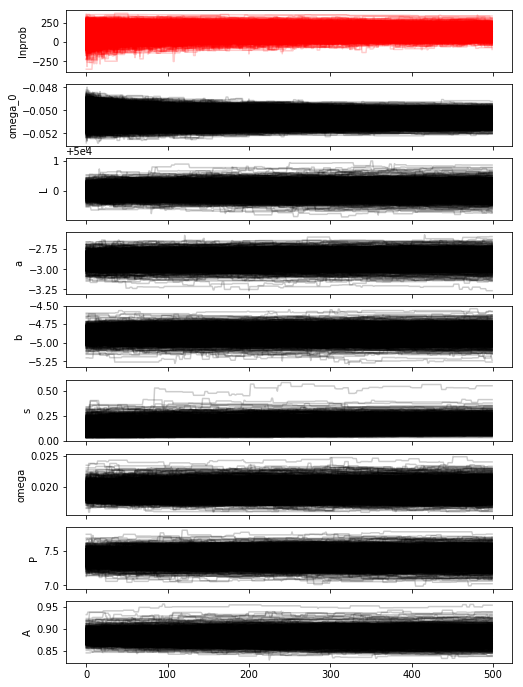

0    0.917778
Name: A_true_E, dtype: float64

In [235]:
# Change me
star_to_try = 0
binary_to_try = 0
band_to_try = 'E'

# Plot chains output
plot_chains(sampler, ranges, data_emcee, star=star_to_try, 
            binary_star=binary_to_try, band=band_to_try)

data.iloc[[star_to_try]]['A_true_' + band_to_try]

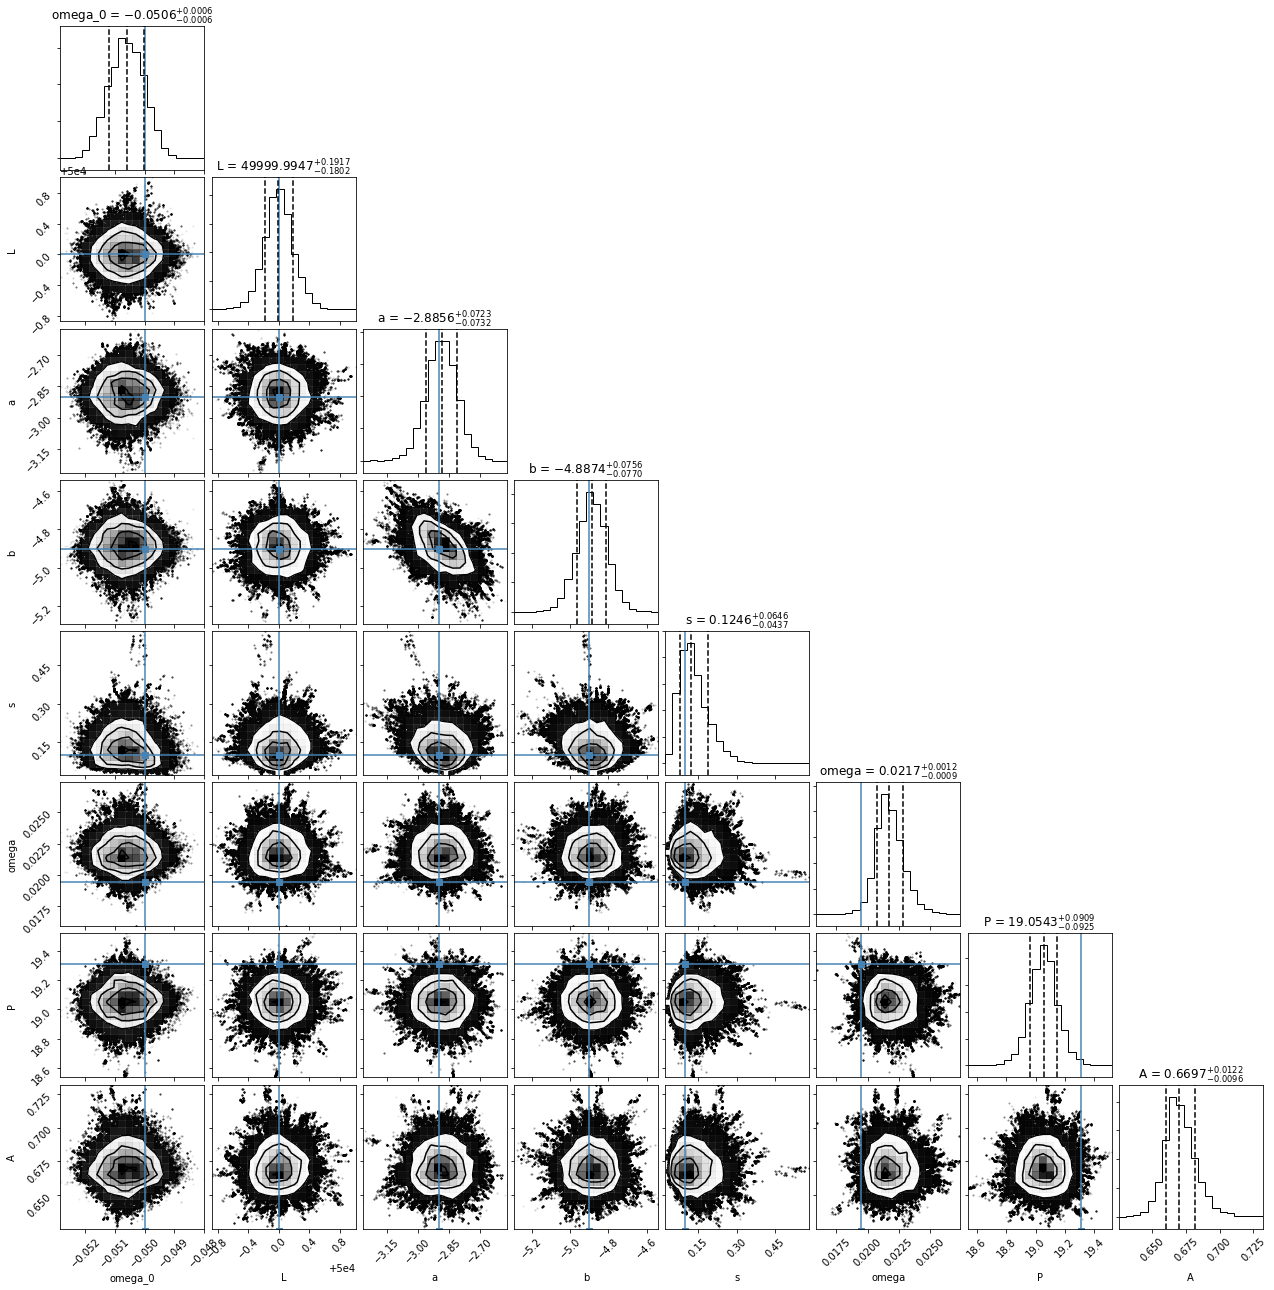

,omega_true,omega_exp,omega_sigma,P_true,P_exp,P_sigma,A_true_E,A_exp_E,m_true_E,m_exp_E
71,0.019452,-0.029259,0.000988,19.311975,19.053995,0.28581,0.623098,0.403009,10.428371,10.442807


In [238]:
# Change me
star_to_try = 71
binary_to_try = 0
band_to_try = 'E'

# Make a corner plot
plot_corner(sampler, ranges, data_emcee, star=star_to_try, 
            binary_star=binary_to_try, band=band_to_try)

# Get data on star star_to_try
data.iloc[[star_to_try]][['omega_true', 'omega_exp', 'omega_sigma', 'P_true', 
                          'P_exp', 'P_sigma', 'A_true_' + band_to_try, 
                          'A_exp_' + band_to_try, 'm_true_' + band_to_try,
                          'm_exp_' + band_to_try]]

In [146]:
s_true

[0.1, 0.3, 0.5]

# Data saving and plotting
------
First, outline a way to convert back from the emcee format to a format for easy output and comparison.

## Function for computing sample quantiles

In [274]:
def calculate_corner_quantiles(sampler, ranges, data_emcee, data, start=False):
    """Computes requisite quantile levels for all parameters in the model,
    and outputs them to the original data DataFrame object as well as popping
    a, b, s etc parameters in a sensible output.
    """
    
    # Quantiles to work stuff out at. Currently set to the 1sigma level.
    quantiles = np.array([0.16, 0.50, 0.84])
    
    # Get all the parameter names we want to look at
    parameter_names = ['omega_inf', 'P_inf']
    for name in band_names:
        parameter_names.append('A_inf_' + name)
        
    # Initialise rows of the dataframe
    for name in parameter_names:
        data[name] = np.nan
        data[name + '_u'] = np.nan
        data[name + '_l'] = np.nan
    
    # Check if the user specified a start point to plot from
    # CURRENTLY NOT IMPLEMENTED
    if start != False:
        s = start
        print("START VALUES AREN'T IMPLEMENTED YET HERE sorry")
    else:
        s = 0
    
    # Loop over all parameters for stars
    for a_star in range(N_good):
        # We grab the original ID of the star so we can put it in the right
        # place in the original DataFrame. Any failed stars will shift the
        # order of everything a bit, making this necessary.
        a_star_ID = data_emcee['ID'][a_star]
        
        # Firstly, do the band independent bits
        # Omega
        data.loc[a_star_ID, 'omega_inf' + '_l'],\
            data.loc[a_star_ID, 'omega_inf'],\
            data.loc[a_star_ID, 'omega_inf' + '_u'] = \
            corner.quantile(sampler.flatchain[:, ranges['omega'][a_star]], 
                            quantiles)
            
        # Period
        data.loc[a_star_ID, 'P_inf' + '_l'],\
            data.loc[a_star_ID, 'P_inf'],\
            data.loc[a_star_ID, 'P_inf' + '_u'] = \
            corner.quantile(sampler.flatchain[:, ranges['P'][a_star]], 
                            quantiles)
        
        # Next, do the band dependent bits        
        for param_name, band_number in zip(parameter_names[2:], range(N_bands)):
            data.loc[a_star_ID, param_name + '_l'],\
                data.loc[a_star_ID, param_name],\
                data.loc[a_star_ID, param_name + '_u'] = \
                corner.quantile(sampler.flatchain[:, ranges['A'][a_star 
                    + N_good*band_number]], quantiles)
        
        # Update the user
        sys.stdout.write("\rProcessed star {}".format(a_star_ID))
        sys.stdout.flush()
        
    # Work out omega_0, L too
    sys.stdout.write("\rProcessing omega_0 and L")
    sys.stdout.flush()
    omega_0 = corner.quantile(sampler.flatchain[:, ranges['omega_0']], quantiles)
    L = corner.quantile(sampler.flatchain[:, ranges['L']], quantiles)
    
    # Finish & return
    sys.stdout.write("\rProcessing done =)")
    sys.stdout.flush()
    return omega_0, L

## Compare between true & inferred values

In [273]:
# Calculate inferred values and also get omega_0 and L
omega_0_inf, L_inf = calculate_corner_quantiles(sampler, ranges, 
                                                data_emcee, data)
print('Found omega_0 as: ({:.5f} +{:.5f} -{:.5f})mas'.format(
    omega_0_inf[1], 
    omega_0_inf[2] - omega_0_inf[1], 
    omega_0_inf[1] - omega_0_inf[0]))
      
print('Found L as: ({:.3f} +{:.3f} -{:.3f})pc'.format(
    L_inf[1], 
    L_inf[2] - L_inf[1], 
    L_inf[1] - L_inf[0]))

Processing done =)Found omega_0 as: (-0.05061 +0.00060 -0.00061)mas
Found L as: (49999.995 +0.192 -0.180)pc


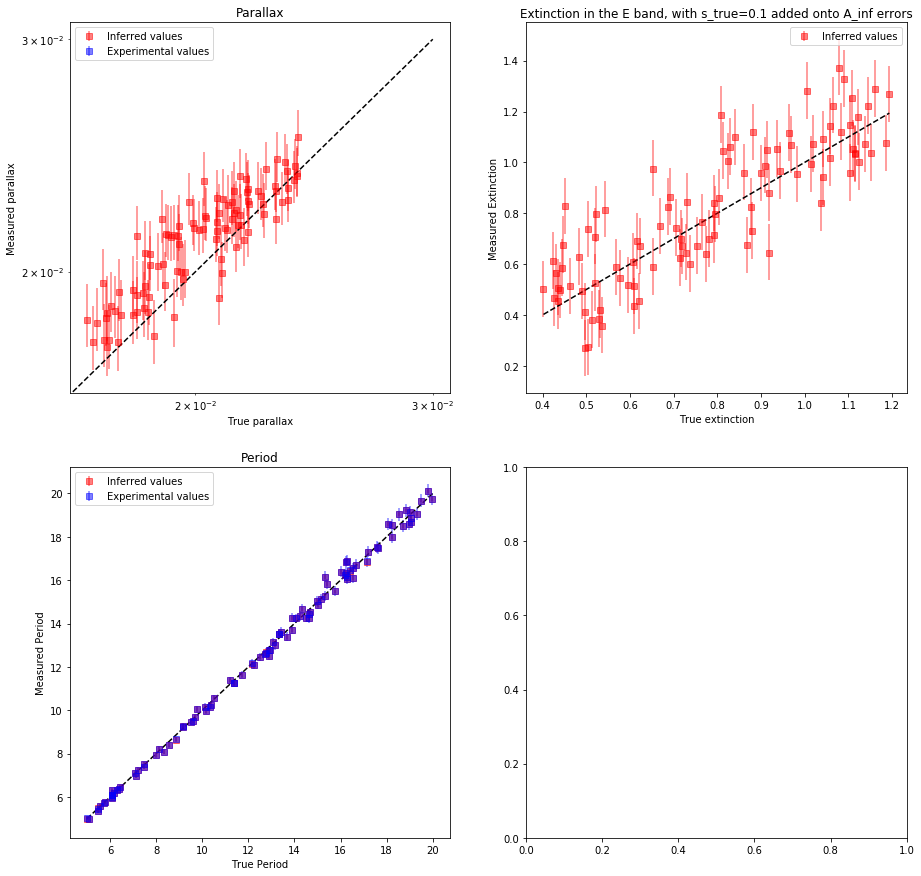

In [276]:
# Let's plot some comparisons on a 2x2 figure!
fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# Parallax

# Calculate lower and upper bounds, also set any NaNs to 0
inf_error = np.array([np.array(data['omega_inf'] - data['omega_inf_l']),
                      np.array(data['omega_inf_u'] - data['omega_inf'])])
inf_error = np.where(np.isfinite(inf_error), inf_error, 0)


ax[0][0].set_title('Parallax')
ax[0][0].set_xscale("log", nonposx='clip')
ax[0][0].set_yscale("log", nonposy='clip')

ax[0][0].errorbar(data['omega_true'], data['omega_inf'], 
                  yerr=inf_error,
                  fmt='sr', label='Inferred values', alpha=0.5
                 )
ax[0][0].errorbar(data['omega_true'], data['omega_exp'], 
                  yerr=data['omega_sigma'],
                  fmt='sb', label='Experimental values', alpha=0.5
                 )
ax[0][0].plot([0, 0.03], [0, 0.03], 'k--')
ax[0][0].set_xlabel('True parallax')
ax[0][0].set_ylabel('Measured parallax')
ax[0][0].legend()


# Extinction
band = 'E'
band_number = band_names.index(band)
band_s = s_true[band_number]
inf_error = np.array([np.array(data['A_inf_' + band] 
                               - data['A_inf_' + band + '_l']) + band_s,
                      np.array(data['A_inf_' + band + '_u'] 
                               - data['A_inf_' + band]) + band_s])
inf_error = np.where(np.isfinite(inf_error), inf_error, 0)

ax[0][1].set_title('Extinction in the {} band, with s_true={} added onto A_inf errors'.format(band, s_true[band_number]))
ax[0][1].errorbar(data['A_true_' + band], data['A_inf_' + band], 
                  yerr=inf_error,
                  fmt='sr', label='Inferred values', alpha=0.5
                 )
#ax[0][1].errorbar(data['A_true_' + band], data['A_exp_' + band], 
#                  yerr=data['A_sigma_' + band],
#                  fmt='sb', label='Experimental values', alpha=0.5
#                 )
#ax[0][1].plot(data['A_true_' + band], 
#              starting_guess[ranges['A'][band_number * N_good
#                                         :(band_number+1) * N_good]],
#              'sg', label='Starting guesses', alpha=0.5)

#ax[0][1].plot(data['A_true_' + band], 
#              data['m_exp_' + band] 
#              - a_true[band_number] * np.log10(data['P_exp'])
#              - b_true[band_number] + 5*np.log10(data['omega_exp']-0.05) -10,
#              'sy', label='Exp implied As', alpha=0.5)

#ax[0][1].plot(data['A_true_' + band], 
#              data['m_true_' + band] 
#              - a_true[band_number] * np.log10(data['P_true'])
#              - b_true[band_number] + 5*np.log10(data['omega_true']) -10,
#              'sk', label='True implied As', alpha=0.5)


xmin = data['A_true_' + band].min()
xmax = data['A_true_' + band].max()

ax[0][1].plot([xmin, xmax], [xmin, xmax], 'k--')
ax[0][1].set_xlabel('True extinction')
ax[0][1].set_ylabel('Measured Extinction')
ax[0][1].legend()


# Period
inf_error = np.array([np.array(data['P_inf'] - data['P_inf_l']),
                      np.array(data['P_inf_u'] - data['P_inf'])])
inf_error = np.where(np.isfinite(inf_error), inf_error, 0)

ax[1][0].set_title('Period')
ax[1][0].errorbar(data['P_true'], data['P_inf'], 
                  yerr=inf_error,
                  fmt='sr', label='Inferred values', alpha=0.5
                 )
ax[1][0].errorbar(data['P_true'], data['P_exp'], 
                  yerr=data['P_sigma'],
                  fmt='sb', label='Experimental values', alpha=0.5
                 )
ax[1][0].plot([5, 20], [5, 20], 'k--')
ax[1][0].set_xlabel('True Period')
ax[1][0].set_ylabel('Measured Period')
ax[1][0].legend()


plt.show()




# Deprecated code

## Some testing of *s* parameter space

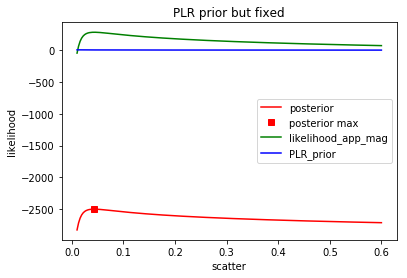

In [296]:
xran = np.linspace(0.01, 0.6, num=200)
yran = []
wran = []
zran = []
for a_scatter in xran:
    a_guess = starting_guess.copy()
    a_guess[ranges['s'][1]] = a_scatter
    yran.append(np.sum(posterior(a_guess, ranges, data_emcee, False)))
    wran.append(np.sum(likelihood_app_mag(a_guess, ranges, data_emcee, False)))
    zran.append(np.sum(prior_PLR(a_guess, ranges, False)))

max_yran = np.argmax(yran)
plt.plot(xran, yran, 'r-', label='posterior')
plt.plot(xran[max_yran], yran[max_yran], 'rs', label='posterior max')
plt.plot(xran, wran, 'g-', label='likelihood_app_mag')
plt.plot(xran, np.asarray(zran), 'b-', label='PLR_prior')
plt.legend()
plt.title('PLR prior but fixed')
plt.xlabel('scatter')
plt.ylabel('likelihood')
plt.show()

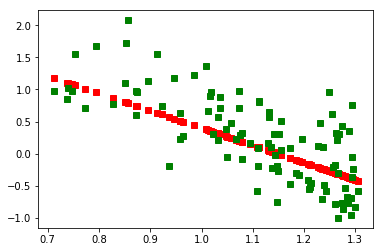

In [306]:
band_n=2
plt.plot(np.log10(data['P_exp']), a_true[band_n] * np.log10(data['P_exp']) + b_true[band_n], 'rs')
plt.plot(np.log10(data['P_exp']), data['M_true_I'], 'gs')
plt.show()

In [199]:
norm(loc=1, scale=0.5).pdf(1)

0.7978845608028654

## Some testing of *A* parameter space

In [184]:
# Constants
a_star = 30
a_band = 'I'

# Find the posterior at the starting guess
band_number = band_names.index(a_band)
points = 200
xran2 = np.linspace(0.4, 2.0, num=points)
yran = []
for a_A in xran:
    a_guess = starting_guess.copy()
    a_guess[ranges['A'][band_number * N_good + a_star]] = a_A
    yran.append(np.sum(posterior(a_guess, ranges, data_emcee, False)))

# Find the posterior for some random walkers
tests = 400
points = 25
xran2 = np.linspace(0.4, 2.0, num=points)
zran = np.zeros((tests, points))
guess_indices = np.random.randint(0, walkers, size=tests)
walker_guesses = sampler.chain[guess_indices, -1, :]
for a_A, i in zip(xran2, range(points)):
    walker_guesses[:, ranges['A'][band_number * N_good + a_star]] = a_A
    
    for j in range(tests):
        zran[j, i] = np.sum(posterior(walker_guesses[j], ranges, data_emcee, False))
    
    sys.stdout.write('\r{} of {}'.format(i+1, points))
    sys.stdout.flush()

24 of 25

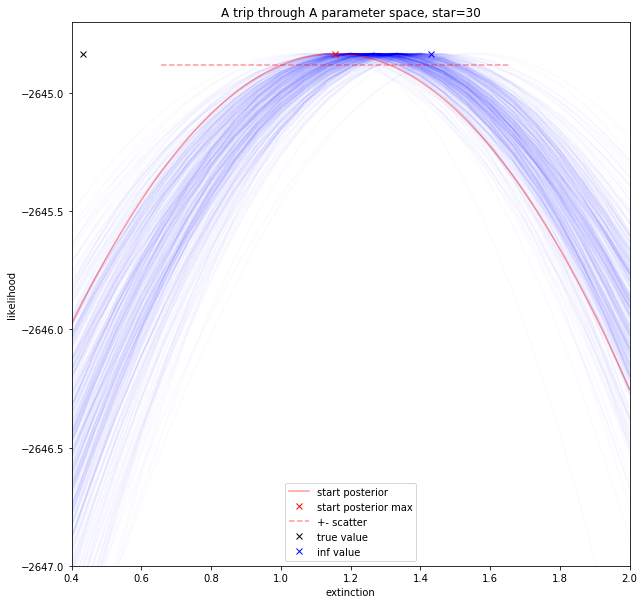

In [192]:
true_A = data.iloc[[a_star]]['A_true_' + a_band]
max_yran = np.amax(yran)
arg_max_yran = np.argmax(yran)

plot_offset = 450

plt.figure(figsize=(10,10))

for i in range(tests):
    max_zran = np.amax(zran[i, :])
    zran_offset = max_yran - max_zran
    plt.plot(xran2, zran[i, :] + zran_offset, 'b-', alpha=0.02)

plt.plot(xran, yran, 'r-', label='start posterior', alpha=0.4)
plt.plot(xran[arg_max_yran], yran[arg_max_yran], 'rx', label='start posterior max')
plt.plot([xran[arg_max_yran]-s_true[band_number], xran[arg_max_yran]+s_true[band_number]], 
         [yran[arg_max_yran]-0.05, yran[arg_max_yran]-0.05], 'r--', label='+- scatter', alpha=0.4)

plt.plot(true_A, yran[arg_max_yran], 'kx', label='true value')
plt.plot(data.iloc[[a_star]]['A_inf_' + a_band], yran[arg_max_yran], 'bx', 
         label='inf value')

#plt.plot(xran, np.asarray(zran), 'g-', label='likelihood_app_mag')
plt.plot()
plt.legend()
plt.title('A trip through A parameter space, star={}'.format(a_star))
plt.xlabel('extinction')
plt.ylabel('likelihood')
plt.xlim(0.4, 2.0)
plt.ylim(-2647, -2644.7)
plt.show()

## From the maximisation function

In [380]:
def maximise_likelihood(star, data, omega_0, L):
    """Maximises a given star's likelihood in order to find a good initial 
    guess at its parameters.
    
    Currently, this takes omega, omega_0, L, m and M values as given, and only 
    fits for A. This has, in the past, stopped the minimisation function
    from being a colossal prick
    
    If the function fails for whatever reason (usually because it can't stop 
    getting -np.inf for a given star,) then success will be set to False and 
    the star will not be added to the parameters to solve for. If this happens, 
    then the user should really try and work out why (and get the star working)
    before proceeding, to ensure that selection effects stemming from the
    effectiveness of this guesser do not appear in the final model.
    """
    # Assume we're gonna get through ok
    success = True
    
    # A synthetic ranges dictionary to trick posterior() into working
    ranges = {'omega':0,
              'omega_0':1,
              'L':2,
              'A':list(range(3, 3 + 1*N_bands)),
              'm':list(range(3 + 1*N_bands, 3 + 2*N_bands)),
              'M':list(range(3 + 2*N_bands, 3 + 3*N_bands))}
    
    # Set any -ve parallaxes to the PLR implied parallax
    if data['omega_exp'][a_star] <= 0:
        omega = np.power(10, (data['M_exp'][a_star] + data['A_exp'][a_star] 
                                  + 10 - data['m_exp'][a_star]) / 5)
    else:
        omega = data['omega_exp'][a_star]
    
    # Create other guess parameters
    A = data['A_exp'][a_star]
    m = data['m_exp'][a_star]
    M = data['M_exp'][a_star]   
    
    """Check for likelihood_app_mag infinity issues"""
    guess = np.array([omega, omega_0, L, A, m, M])
    likelihood_test = likelihood_app_mag(guess, ranges, data, debug=False)
    if np.isfinite(likelihood_test) == False or likelihood_test < -300:
        print("Star {} gives an instant inf. Attempting to fix.".format(star))
        
        # Slowly change the extinction to see if this fixes the problem
        counter = 1
        while True:
            guess[ranges['A']] += 0.001  
            
            new_likelihood_test = likelihood_app_mag(guess, ranges, data, 
                                                     debug=False)
            
            # If the extinction prior is now false, then I guess we've
            # totally failed to fix this star. =(
            if np.isfinite(prior_extinction(guess, ranges, 
                                            debug=False)) == False:
                print("Prior_extinction is now infinite. Star {} has failed\n"
                      .format(star)
                      + " after {} attempts.".format(counter))
                success = False
                break            
                
            # Otherwise, see if the likelihood is better now:
            elif (np.isfinite(new_likelihood_test) and new_likelihood_test < likelihood_test):
                print("likelihood_app_mag is now finite. Moving on...")
                guess[ranges['A']] -= 0.001  
                break
                
            # Otherwise, update a counter and try the loop again
            else:
                likelihood_test = new_likelihood_test
                counter += 1
                
    """Run scipy minimisation function"""
    if success:
        print("Minimising star {}...".format(star))

        # Remove omega_0, L, m and M from guess so that they're locked
        guess = np.array([omega, A])

        # Multiply the posterior by -1 when returning so that it's 
        # minimized, not maximized
        def function_to_minimize(params, omega_0, L, m, M, ranges, data):
            params = np.insert(params, 1, [omega_0, L])
            params = np.append(params, m)
            params = np.append(params, M)
            return -1 * posterior(params, ranges, data)

        # Actually do the scipy bit
        result = minimize(function_to_minimize, guess, 
                 args=(omega_0, L, m, M, ranges, data), 
                 method='Nelder-Mead',
                 options={'maxiter':2000})

        # 'result' is a scipy.optimize.OptimizeResult object that we need 
        # to split up
        omega = result.x[ranges['omega']]
        A = result.x[list(np.array(ranges['A']) - 2)]
        success = result.success
        
        a_posterior = -1 * function_to_minimize([omega, A], omega_0, 
                            L, m, M, ranges, data)
        
        if success and np.isfinite(a_posterior):
            print("  minimised star {}. Posterior = {}. Omega = {}. A = {}\n"
                  .format(star, a_posterior, omega, A))
        else:
            print("Minimisation failed on star {} after ??? iterations =(\n"
                  .format(star))
    
    return [success, omega, A, m, M]

## More from the maximisation function (how it was at the start of batdog_begins)

In [162]:
def maximise_likelihood(star, data, omega_0, L):
    """Maximises a given star's likelihood in order to find a good initial 
    guess at its parameters.
    
    Currently, this takes omega, omega_0, L, m and M values as given, and only 
    fits for A. This has, in the past, stopped the minimisation function
    from being a colossal prick
    
    If the function fails for whatever reason (usually because it can't stop 
    getting -np.inf for a given star,) then success will be set to False and 
    the star will not be added to the parameters to solve for. If this happens, 
    then the user should really try and work out why (and get the star working)
    before proceeding, to ensure that selection effects stemming from the
    effectiveness of this guesser do not appear in the final model.
    """
    # Console output
    print("\n> Creating a guess for star {}".format(star))
    
    # Assume failure because I have to typecast this.. somewhere. Why not here?
    A_success = False
       
    # Get input parameters to use from data
    A = data['A'][:, star]
    P = data['P'][star]
    m = data['A'][:, star]
    
    
    """Solve for parallax"""
    # We calculate good input data for scipy, and then feed this to the
    # minimisation method.
    def function_to_minimize(omega, omega_0, L, A, m, M, ranges, data):
        """Minimisation function for use with scipy. We multiply by -1 so 
        we're minimising, not maximising!
        """
        # Pop everything in a np.array to interface with existing fns
        params = np.array([omega, omega_0, L, A, m, M])

        return -1*(np.sum(likelihood_parallax(params, ranges, data, True)) 
                   + np.sum(prior_parallax(params, ranges, True)))
    
    # Calculate different initial estimates of the parallax & their probability
    omega_exp = data['omega_exp'][star]
    omega_PLR = np.power(10, (data['M_exp'][a_star] + data['A_exp'][a_star] 
                                  + 10 - data['m_exp'][a_star]) / 5)
    omega_prior = 1/(2*L) * 1e3
    prob_exp = function_to_minimize(omega_exp, omega_0, L, 
                                    A, m, M, ranges, data)
    prob_PLR = function_to_minimize(omega_PLR, omega_0, L, 
                                    A, m, M, ranges, data)
    prob_prior = function_to_minimize(omega_prior, omega_0, L, 
                                      A, m, M, ranges, data)
    
    # Minimise with the most likely 
    if prob_exp < prob_PLR and prob_exp < prob_prior and np.isfinite(prob_exp):
        print("    using experimental parallax value for first guess")
        omega = omega_exp
        omega_success = True
    elif prob_PLR < prob_prior and np.isfinite(prob_PLR):
        print("    using PLR parallax value for first guess")
        omega = omega_PLR
        omega_success = True
    elif np.isfinite(prob_prior):
        print("    using prior parallax value for first guess")
        omega = omega_prior
        omega_success = True
        
    # If all else fails, brute force through parameter space to try and find
    # a value to use. Ranges need setting manually.
    else:
        print("    ah shit nothing has worked yet")
        print("    gonna do this the hard way with 1000 samples...")
        omega_sampled = np.linspace(0.001, 2.0, num=1000)
        prob_sampled = []
        for i in omega_sampled:
            params = np.array([i, 0.0, 1000.0, 0.0, 0.0, 0.0])
            prob_sampled.append(function_to_minimize(i, omega_0, L, 
                                                     A, m, M, ranges, data))
        
        # See if *literally any* of the values are good
        if np.any(np.isfinite(prob_sampled)):
            print("    using sampled parallax value for first guess")
            index_of_minimum = np.argmin(prob_sampled)
            omega = omega_sampled[index_of_minimum]
            omega_success = True
        else:
            print("~~~ failed to make initial omega guess =(")
            omega_success = False
        
    # Minimise with scipy if the above worked and we have a good initial guess
    if omega_success:
        result = minimize(function_to_minimize, omega, 
                          args=(omega_0, L, A, m, M, ranges, data), 
                          method='Nelder-Mead',
                          options={'maxiter':2000, 'disp':True})
    
        # Pull the results out of result, which is a 
        # scipy.optimize.OptimizeResult object that needs care, love, 
        # attention, and the US spelling of optimise
        omega_success = result.success

        # Tell the user that everything went well (hopefully (maybe))
        if omega_success:
            omega_guess = result.x
            print("    guessed omega at {}".format(omega_guess))
        else:
            print("~~~ scipy failed to guess omega =(")
    
    
    """Solve for extinction"""
    # This is easily done with the PLR relationship and using the guessed
    # parallax above to infer an extinction value.
    if omega_success:
        A_guess = m - M - 10 + 5*np.log10(omega_guess)
        print("    guessed A at {}".format(A_guess))
        print("    original A was {}".format(data['A_exp'][star]))
        
        # Check that the posterior for this star isn't something stupid
        # If it is, then we've fucked up lol
        params_guess = np.array([omega_guess, omega_0, L, A_guess, m, M])
        posterior_guess = posterior(params_guess, ranges, data, debug=True)
        A_success = np.isfinite(posterior_guess)
        print("    posterior evaluates to {}".format(posterior_guess))
        
        if A_success == False:
            print("~~~ failed to guess A due to poor posterior")   
    
    
    """Return result"""
    if A_success:
        print("    storing this good result for star {}".format(star))
        return [omega_guess, A_guess, m, M]
        
    else:
        print("~~~ star {} will not be stored in the final model".format(star))
        return [False]

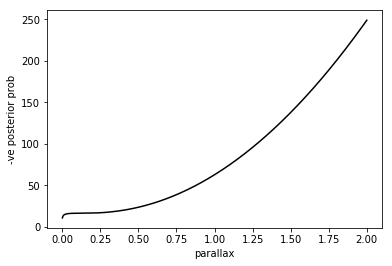

In [172]:
ranges = {'omega':0,
          'omega_0':1,
          'L':2,
          'A':list(range(3, 3 + 1*N_bands)),
          'm':list(range(3 + 1*N_bands, 3 + 2*N_bands)),
          'M':list(range(3 + 2*N_bands, 3 + 3*N_bands))}

a_star = 33

##############

some_data = data.iloc[[a_star]]
a_A = some_data['A_exp'][a_star]
a_m = some_data['m_exp'][a_star]
a_M = some_data['M_exp'][a_star]

xrange = np.linspace(0.001, 2.0, num=1000)
yrange = []
for i in xrange:
    params = np.array([i, 0.0, 1000.0, 0.0, 0.0, 0.0])
    yrange.append(-1*(np.sum(likelihood_parallax(params, ranges, some_data, True)) 
                   + np.sum(prior_parallax(params, ranges, True))))
    
plt.plot(xrange, yrange, 'k-')
plt.xlabel('parallax')
plt.ylabel('-ve posterior prob')
plt.show()


## Run the maximisation function for all stars

In [167]:
# Define ranges that will be where data is stored in the overall
# mcmc position vector.

guess_omega = []
guess_A = []
guess_m = []
guess_M = []
guess_successes = []
guess_fails = []

# Cycle over all stars and get guesses on their parameters
for a_star in range(N):
    maximisation_result = maximise_likelihood(a_star, data.iloc[[a_star]],
                                              guess_omega_0, guess_L)
    
    # Only add the star to the parameter set if it's not going to cause issues.
    # We ascertain this with np.any(), which returns False for [False] (as the 
    # single array element in that isn't true)
    if np.any(maximisation_result):
        guess_omega.append(maximisation_result[0])
        guess_A.append(maximisation_result[1])
        guess_m.append(maximisation_result[2])
        guess_M.append(maximisation_result[3])
        guess_successes.append(a_star)
    else:
        guess_fails.append(a_star)

print('All done! We failed {} times.'.format(len(guess_fails)))


> Creating a guess for star 0
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 17.462566
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.57986574]
    guessed A at [1.08599221]
    original A was 0.8896045984425304
    posterior evaluates to -10.334307268996515
    storing this good result for star 0

> Creating a guess for star 1
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 18.137256
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.76338401]
    guessed A at [1.976072]
    original A was 1.5387955952605645
    posterior evaluates to -13.276337638793482
    storing this good result for star 1

> Creating a guess for star 2
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 14.844119
         I

/u/h/eh594/.conda/envs/emily3/lib/python3.6/site-packages/ipykernel/__main__.py:10: RuntimeWarning: divide by zero encountered in log



    guessed omega at [0.24915696]
    guessed A at [2.18889264]
    original A was 1.2242519253636444
    posterior evaluates to -11.069788450392316
    storing this good result for star 7

> Creating a guess for star 8
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.757386
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.464878]
    guessed A at [1.92226384]
    original A was 1.5330862335554545
    posterior evaluates to -9.636968223249294
    storing this good result for star 8

> Creating a guess for star 9
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.666752
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.47155286]
    guessed A at [1.31159256]
    original A was 0.7331084931731461
    posterior evaluates to -9.83673980551529
    storing this good result fo

Optimization terminated successfully.
         Current function value: 10.509467
         Iterations: 23
         Function evaluations: 46
    guessed omega at [0.00050143]
    guessed A at [-11.1951979]
    original A was 0.7143572367220545

prior_extinction encountered infs in:
(array([0]),)
    posterior evaluates to -inf
~~~ failed to guess A due to poor posterior
~~~ star 33 will not be stored in the final model

> Creating a guess for star 34
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.286517
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.42090971]
    guessed A at [1.9548167]
    original A was 1.1749025876386152
    posterior evaluates to -10.404522161291164
    storing this good result for star 34

> Creating a guess for star 35

likelihood_parallax encountered infs in:
(array([0]),)
    using experimental parallax value for first guess
Optimization terminated 

Optimization terminated successfully.
         Current function value: 17.556038
         Iterations: 10
         Function evaluations: 20
    guessed omega at [0.69711892]
    guessed A at [1.49936081]
    original A was 0.9074466029426809
    posterior evaluates to -13.430108752040343
    storing this good result for star 61

> Creating a guess for star 62
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 15.455422
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.2757178]
    guessed A at [0.50890745]
    original A was 0.31484434906427816
    posterior evaluates to -8.95072440882705
    storing this good result for star 62

> Creating a guess for star 63
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 15.334695
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.28006289]
 

    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.222425
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.33155923]
    guessed A at [0.87401566]
    original A was 0.6530081631504009
    posterior evaluates to -10.777455070876172
    storing this good result for star 79

> Creating a guess for star 80
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 14.837501
         Iterations: 8
         Function evaluations: 16
    guessed omega at [0.19624982]
    guessed A at [0.59852027]
    original A was 0.3379103267555543
    posterior evaluates to -9.558340529885207
    storing this good result for star 80

> Creating a guess for star 81

likelihood_parallax encountered infs in:
(array([0]),)

likelihood_parallax encountered infs in:
(array([0]),)
    using experimental parallax value for first guess
Optimiz

Optimization terminated successfully.
         Current function value: 16.735301
         Iterations: 13
         Function evaluations: 26
    guessed omega at [1.39795912]
    guessed A at [1.46902115]
    original A was 0.8696739177212992
    posterior evaluates to -10.83943525594211
    storing this good result for star 97

> Creating a guess for star 98
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 17.060137
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.47793537]
    guessed A at [0.40481861]
    original A was 0.16956816999053828
    posterior evaluates to -10.29733296920159
    storing this good result for star 98

> Creating a guess for star 99
    using experimental parallax value for first guess
Optimization terminated successfully.
         Current function value: 16.218853
         Iterations: 9
         Function evaluations: 18
    guessed omega at [0.31454607]


In [178]:
data.iloc[[47]]

,ID,ra,dec,r_true,omega_true,P_true,s_true,M_true,A_true,m_true,omega_exp,omega_sigma,m_exp,m_sigma,A_exp,A_sigma,P_exp,P_sigma,M_exp,M_sigma
47,47,173.806324,-61.025872,3829.266374,0.261147,18.728441,0.0,2.264246,0.327156,15.50698,0.253377,0.018816,15.506086,0.001341,0.178841,0.143073,18.618057,0.110836,2.271177,0.047001


In [168]:
guess_fails

[33, 72]

In [20]:
np.arange(0, 10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

## Test of how matrices work in numpy

In [9]:
hi = np.array([[2, 2], 
               [0, 0],
               [-2, -2]])

me = np.array([1, 3])

hi * me

array([[ 2,  6],
       [ 0,  0],
       [-2, -6]])

## Old ranges code

In [ ]:
ranges = {'omega':list(range(0,N_good)),
          'omega_0':N_good,
          'L':N_good+1,
          'A':list(range(N_good+2, N_good+2 + 1*N_good*N_bands)),
          'm':list(range(N_good+2 + 1*N_good*N_bands, N_good+2 + 2*N*N_bands)),
          'M':list(range(N_good+2 + 2*N_good*N_bands, N_good+2 + 3*N*N_bands))}

The Gaussian sum way of doing things (sucks)

In [151]:
N_points = 300
test_r = np.linspace(30000, 70000, num=N_points)

a_star = 0
likelihood = np.zeros(N_points)

# Cycle along the beam
r_i = 0
for a_r in zip(test_r):
    sys.stdout.write('\r{}'.format(r_i))
    sys.stdout.flush()
    # Evaluate stars at beam test points
    for along, a_weight in zip(distances_along_beam[a_star], star_weights[a_star]):
        likelihood[r_i] += norm(along, data_prior['r_sigma'][a_star]).pdf(a_r) * a_weight
    r_i += 1

299

## Some code for a different parallax prior using stars as Gaussians, not points

The Gaussian sum way of doing things (sucks - it doesn't retrieve the shape of the distribution properly, and just spends ages to return a Gaussian centred on the mean distance. I think this would only work if star positional errors were very small. Also it's coded terribly, it takes fucking forever. For loops suck!)

In [151]:
N_points = 300
test_r = np.linspace(30000, 70000, num=N_points)

a_star = 0
likelihood = np.zeros(N_points)

# Cycle along the beam
r_i = 0
for a_r in zip(test_r):
    sys.stdout.write('\r{}'.format(r_i))
    sys.stdout.flush()
    # Evaluate stars at beam test points
    for along, a_weight in zip(distances_along_beam[a_star], star_weights[a_star]):
        likelihood[r_i] += norm(along, data_prior['r_sigma'][a_star]).pdf(a_r) * a_weight
    r_i += 1

299

## Let's import some data

In [ ]:
from astropy.io import ascii

ogle_raw = ascii.read(data_dir + 'ogle_lmc_cepheid_cat')
ogle_raw.convert_bytestring_to_unicode() ### some of the columns read in as bytestrings instead of strings. I think it was an astroconda update.

ogle_raw_temp = ogle_raw.to_pandas()  # you can convert directly from an astropy table to a pandas df
ogle_raw_df = ogle_raw_temp[['Star', 'Mode', '_RAJ2000', '_DEJ2000', '<Imag>', '<Vmag>', 'Per', 'e_Per']]
ogle_raw_df = ogle_raw_df.iloc[2:] ## scrapping the first two lines - remnants of the header
ogle_raw_df.reset_index(drop=True, inplace=True) ## resetting the index because i dropped the first two lines
ogle_raw_df.rename(columns = {'Star': 'ID', 'Mode': 'type', '_RAJ2000': 'ra', '_DEJ2000' : 'dec',  '<Imag>' : 'm_I', '<Vmag>': 'm_V', 'Per': 'P', 'e_Per' : 'P_sigma'}, inplace=True) ## renaming the columns to match your naming scheme.

num_cols = ['ra', 'dec', 'm_I', 'm_V', 'P', 'P_sigma'] ## numeric columns - need to convert to floats
for cols in num_cols:
    ogle_raw_df[cols] = pd.to_numeric(ogle_raw_df[cols], errors='coerce') ## errors='coerce' sets invalid reads to NaN, means that missing data is flagged properly


#### Only thing below here in batdog.ipynb that I changed was commenting out your reading into ogle_raw_df. I left everything from where you were putting things into ogle_cepheids onwards.

## plots make a nice PL now!!



### OGLE

In [284]:
from astropy.io import ascii

In [285]:
ogle_raw = ascii.read(data_dir + 'ogle_lmc_cepheid_cat')

# Some of the columns read in as bytestrings instead of strings.
ogle_raw.convert_bytestring_to_unicode()
ogle_raw

_RAJ2000,_DEJ2000,Star,Mode,RAJ2000,DEJ2000,<Imag>,<Vmag>,Per,e_Per,Iamp,R21,R31,LC,PerM,IampM,PerS,IampS
str11,str11,str4,str8,str11,str11,str6,str6,str11,str10,str6,str6,str6,str2,str10,str6,str10,str6
deg,deg,,,h:m:s,d:m:s,mag,mag,d,d,mag,,,,d,mag,d,mag
-----------,-----------,----,--------,-----------,-----------,------,------,-----------,----------,------,------,------,--,----------,------,----------,------
067.7405417,-69.0603889,0001,1O,04 30 57.73,-69 03 37.4,17.777,18.173,0.3068149,0.0000002,0.349,0.258,0.089,LC,,,,--
067.9460000,-69.8193333,0002,F,04 31 47.04,-69 49 09.6,15.672,16.412,3.1181195,0.0000161,0.257,0.296,0.101,LC,,,,--
068.7737917,-70.4241389,0003,1O,04 35 05.71,-70 25 26.9,17.847,18.359,0.3500934,0.0000006,0.340,0.193,0.095,LC,,,,--
068.8339583,-69.8021389,0004,1O,04 35 20.15,-69 48 07.7,15.128,15.688,2.2296063,0.0000057,0.249,0.156,0.012,LC,,,,--
068.8813333,-69.7349722,0005,F,04 35 31.52,-69 44 05.9,14.661,15.413,5.6120581,0.0000135,0.521,0.431,0.167,LC,,,,--
068.9256667,-69.7247778,0006,1O,04 35 42.16,-69 43 29.2,14.697,15.365,3.2949240,0.0000124,0.212,0.113,0.049,LC,,,,--
069.1252083,-68.6265833,0007,1O,04 36 30.05,-68 37 35.7,16.932,17.561,0.7090850,0.0000013,0.189,0.166,0.123,LC,,,,--


In [287]:
# Read stuff in to a nicer pandas DataFrame.
#ogle_raw_df = pd.DataFrame({
#     'ID':pd.Series(ogle_raw['Star'][2:], dtype=np.int),
#     'type':pd.Series(ogle_raw['Mode'][2:], dtype=str),
#     'ra':pd.Series(ogle_raw['_RAJ2000'][2:], dtype=np.float),
#     'dec':pd.Series(ogle_raw['_DEJ2000'][2:], dtype=np.float),
#     'm_I':pd.Series(np.genfromtxt(ogle_raw['<Imag>'][2:])),
#     'm_V':pd.Series(np.genfromtxt(ogle_raw['<Vmag>'][2:])),
#     'P':pd.Series(ogle_raw['Per'][2:], dtype=np.float),
#     'P_sigma':pd.Series(ogle_raw['e_Per'][2:], dtype=np.float)
#     })

ogle_raw_temp = ogle_raw.to_pandas()  # you can convert directly from an astropy table to a pandas df
ogle_raw_df = ogle_raw_temp[['Star', 'Mode', '_RAJ2000', '_DEJ2000', '<Imag>', '<Vmag>', 'Per', 'e_Per']]
ogle_raw_df = ogle_raw_df.iloc[2:] ## scrapping the first two lines - remnants of the header
ogle_raw_df.reset_index(drop=True, inplace=True) ## resetting the index because i dropped the first two lines
ogle_raw_df.rename(columns = {'Star': 'ID', 'Mode': 'type', '_RAJ2000': 'ra', '_DEJ2000' : 'dec',  '<Imag>' : 'm_I', '<Vmag>': 'm_V', 'Per': 'P', 'e_Per' : 'P_sigma'}, inplace=True) ## renaming the columns to match your naming scheme.

num_cols = ['ra', 'dec', 'm_I', 'm_V', 'P', 'P_sigma'] ## numeric columns - need to convert to floats
for cols in num_cols:
    ogle_raw_df[cols] = pd.to_numeric(ogle_raw_df[cols], errors='coerce') ## errors='coerce' sets invalid reads to NaN, means that missing data is flagged properly

# Exclude all Cepheids that are NOT a) first mode pulsators, b) have periods in
# the range log(P) > 0.4, c) do not have both I and V band photometry
ogle_cepheids = ogle_raw_df.copy()[np.log10(np.array(ogle_raw_df.P)) > 0.4]
ogle_cepheids = ogle_cepheids[ogle_cepheids.type == 'F       ']
ogle_cepheids = ogle_cepheids[np.isfinite(ogle_cepheids.m_I)]
ogle_cepheids = ogle_cepheids[np.isfinite(ogle_cepheids.m_V)]

# Constants from Jacszyn 2016
ogle_a = -3.317  # mag
ogle_b = 15.890  # mag
r_LMC = 49970  # pc

# Calculate the Wesenheit extinction-independent magnitude
ogle_cepheids['W_IVI'] = ogle_cepheids['m_I'] - 1.55 * (ogle_cepheids['m_V'] 
                                                        - ogle_cepheids['m_I'])
ogle_cepheids['W_ref'] = ogle_a * np.log10(ogle_cepheids['P']) + ogle_b
ogle_cepheids['r_exp'] = r_LMC * np.power(10, 
                          (ogle_cepheids['W_IVI'] - ogle_cepheids['W_ref'])/5.)


In [288]:
ogle_cepheids

,ID,type,ra,dec,m_I,m_V,P,P_sigma,W_IVI,W_ref,r_exp
1,0002,F,67.946000,-69.819333,15.672,16.412,3.118120,0.000016,14.52500,14.251758,56670.599023
4,0005,F,68.881333,-69.734972,14.661,15.413,5.612058,0.000014,13.49540,13.405162,52090.315683
11,0012,F,69.453042,-67.214417,15.469,16.067,2.660188,0.000002,14.54210,14.480566,51406.283958
15,0016,F,69.635500,-67.646306,13.707,14.787,10.506456,0.001555,12.03300,12.501830,40266.458470
16,0017,F,69.736792,-69.688389,15.345,15.992,3.677256,0.000030,14.34215,14.014157,58117.630213
17,0018,F,69.745750,-68.956889,15.222,16.051,4.047853,0.000028,13.93705,13.875836,51398.708727
20,0021,F,69.879000,-69.261833,14.722,15.491,5.457975,0.000026,13.53005,13.445266,51959.630419
24,0025,F,70.226542,-69.115083,15.343,16.157,3.733500,0.000010,14.08130,13.992291,52060.842460
25,0026,F,70.301000,-68.799750,15.466,16.081,2.570676,0.000003,14.51275,14.529873,49577.520364
26,0027,F,70.331208,-67.335583,15.039,15.641,3.522947,0.000005,14.10590,14.075913,50664.859916


In [289]:
np.log10(np.asarray(ogle_raw['Per'][2:], dtype=np.float))

array([-0.51312355,  0.49389276, -0.45581608, ..., -0.55873607,
       -0.65314944, -0.59161026])

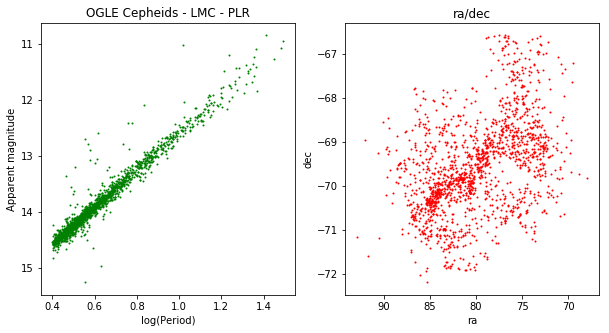

In [290]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# PL plot
ax[0].plot(np.log10(ogle_cepheids['P']), ogle_cepheids['W_IVI'], 'g.', ms=2)
ax[0].set_xlabel("log(Period)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].set_title("OGLE Cepheids - LMC - PLR")
ax[0].invert_yaxis()

# RA/DEC plot
ax[1].plot(ogle_cepheids['ra'], ogle_cepheids['dec'], 'r.', ms=2)
ax[1].set_xlabel("ra")
ax[1].set_ylabel("dec")
ax[1].set_title("ra/dec")
ax[1].invert_xaxis()

plt.show()

### VMC

In [57]:
vmc_cepheids_raw = pd.read_csv(data_dir + 'vmc_cepheids.csv')
vmc_cepheids_raw.keys()

Index(['IAUNAME', 'SOURCEID', 'VARID', 'FIELDID', 'CUEVENTID', 'RA2000',
       'DEC2000', 'CEPHTYPE', 'CEPHSUBTYPE', 'CEPHMODE', 'PERIOD', 'YNEPOCHS',
       'YMEANMAG', 'YMAGERR', 'YAMPL', 'YAMPLERR', 'JNEPOCHS', 'JMEANMAG',
       'JMAGERR', 'JAMPL', 'JAMPLERR', 'KSNEPOCHS', 'KSMEANMAG', 'KSMAGERR',
       'KSAMPL', 'KSAMPLERR', 'NOTES', 'ORIGVSAREL', 'ORIGVSASOURCEID',
       'CATALOGUE', 'EXTERNALID'],
      dtype='object')

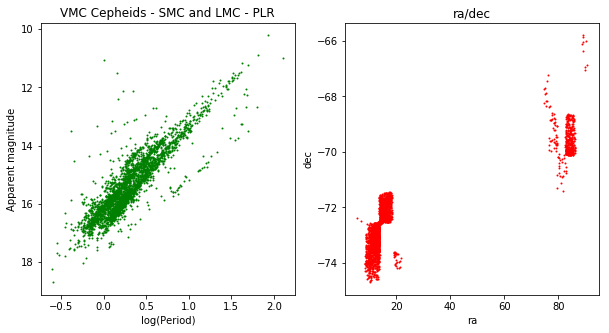

In [103]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# PL plot
ax[0].plot(np.log10(vmc_cepheids_raw['PERIOD']), vmc_cepheids_raw['KSMEANMAG'], 'g.', ms=2)
ax[0].set_xlabel("log(Period)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].set_title("VMC Cepheids - SMC and LMC - PLR")
ax[0].invert_yaxis()

# RA/DEC plot
ax[1].plot(vmc_cepheids_raw['RA2000'], vmc_cepheids_raw['DEC2000'], 'r.', ms=2)
ax[1].set_xlabel("ra")
ax[1].set_ylabel("dec")
ax[1].set_title("ra/dec")
ax[1].invert_xaxis()

plt.show()

In [79]:
vmc_cepheids_all = vmc_cepheids_raw.rename(index=str, columns={
                                            'IAUNAME':'IAU_ID', 
                                            'FIELDID':'field_ID',
                                            'RA2000':'ra',
                                            'DEC2000':'dec', 
                                            'CEPHTYPE':'type', 
                                            'CEPHSUBTYPE':'sub_type', 
                                            'CEPHMODE':'P_mode', 
                                            'PERIOD':'P', 
                                            'YMEANMAG':'m_Y', 
                                            'YMAGERR':'m_sigma_Y', 
                                            'JMEANMAG':'m_J',
                                            'JMAGERR':'m_sigma_J',
                                            'KSMEANMAG':'m_K', 
                                            'KSMAGERR':'m_sigma_K'})
jupyter_go_away = 1 + 1

Make a VMC Cepheids data frame that only has good cepheids in the LMC.

In [93]:
# Make a brand new copied data frame and only containing LMC cepheids.
#vmc_cepheids_LMC = vmc_cepheids_all.copy()[np.core.defchararray.startswith(
#    np.asarray(vmc_cepheids_all['field_ID'], dtype=str), 'LMC')]

vmc_cepheids_LMC = vmc_cepheids_all.copy()[np.where(np.logical_and(vmc_cepheids_all['ra']]

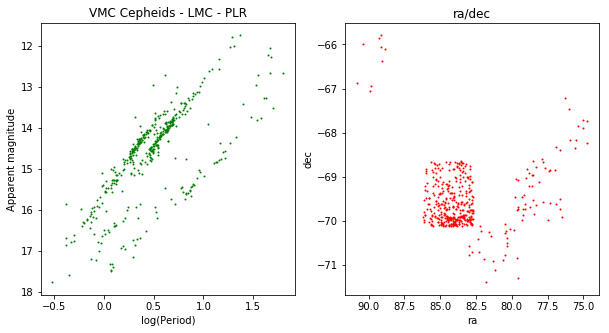

In [111]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# PL plot
ax[0].plot(np.log10(vmc_cepheids_LMC['P']), vmc_cepheids_LMC['m_K'], 'g.', ms=2)
ax[0].set_xlabel("log(Period)")
ax[0].set_ylabel("Apparent magnitude")
ax[0].set_title("VMC Cepheids - LMC - PLR")
ax[0].invert_yaxis()

# RA/DEC plot
ax[1].plot(vmc_cepheids_LMC['ra'], vmc_cepheids_LMC['dec'], 'r.', ms=2)
ax[1].set_xlabel("ra")
ax[1].set_ylabel("dec")
ax[1].set_title("ra/dec")
ax[1].invert_xaxis()

plt.show()

In [109]:
vmc_cepheids_LMC

,IAU_ID,SOURCEID,VARID,field_ID,CUEVENTID,ra,dec,type,sub_type,P_mode,...,KSNEPOCHS,m_K,m_sigma_K,KSAMPL,KSAMPLERR,NOTES,ORIGVSAREL,ORIGVSASOURCEID,CATALOGUE,EXTERNALID
2,VMC J050511.33-671245.47,5.583558e+11,8367.0,LMC_7_3,871.0,76.297125,-67.212583,T2CEP,'W Vir',NONE,...,16.0,15.217000,0.0090,0.18,NaN,NONE,VMCv20130805,5.583511e+11,OGLE-IV,OGLE-LMC-T2CEP-039
3,VMC J050356.30-672724.77,5.583559e+11,8364.0,LMC_7_3,871.0,75.984625,-67.456833,T2CEP,'RV Tau',NONE,...,16.0,12.212000,0.0900,0.34,NaN,NONE,VMCv20130805,5.583512e+11,OGLE-IV,OGLE-LMC-T2CEP-032
4,VMC J050013.00-674243.76,5.583561e+11,8365.0,LMC_7_3,871.0,75.054167,-67.712139,T2CEP,'pW Vir',NONE,...,16.0,14.720000,0.0130,0.34,NaN,NONE,VMCv20130805,5.583514e+11,OGLE-IV,OGLE-LMC-T2CEP-023
5,VMC J045851.29-674423.91,5.583561e+11,8385.0,LMC_7_3,871.0,74.713708,-67.739972,ACEP,NONE,FO,...,16.0,16.575001,0.0140,0.16,NaN,NONE,VMCv20130805,5.583514e+11,OGLE-IV,OGLE-LMC-ACEP-009
6,VMC J050136.69-675133.10,5.583562e+11,8388.0,LMC_7_3,871.0,75.402875,-67.859194,ACEP,NONE,F,...,16.0,16.261000,0.0060,0.30,NaN,NONE,VMCv20130805,5.583515e+11,OGLE-IV,OGLE-LMC-ACEP-016
7,VMC J050008.26-675404.25,5.583562e+11,8387.0,LMC_7_3,871.0,75.034417,-67.901194,ACEP,NONE,F,...,16.0,15.862000,0.0080,0.29,NaN,NONE,VMCv20130805,5.583515e+11,OGLE-IV,OGLE-LMC-ACEP-014
8,VMC J050335.57-681015.14,5.583564e+11,8363.0,LMC_7_3,871.0,75.899250,-68.171167,T2CEP,'BL Her',NONE,...,16.0,NaN,NaN,NaN,NaN,NONE,VMCv20130805,5.583517e+11,OGLE-IV,OGLE-LMC-T2CEP-030
9,VMC J050203.13-680930.44,5.583564e+11,8389.0,LMC_7_3,871.0,75.513042,-68.158444,ACEP,NONE,F,...,16.0,16.809999,0.0150,0.25,NaN,NONE,VMCv20130805,5.583517e+11,OGLE-IV,OGLE-LMC-ACEP-017
10,VMC J050738.94-682005.99,5.583564e+11,8362.0,LMC_7_3,871.0,76.912250,-68.334972,T2CEP,'W Vir',NONE,...,16.0,14.360000,0.0210,0.59,NaN,NONE,VMCv20130805,5.583517e+11,OGLE-IV,OGLE-LMC-T2CEP-046
11,VMC J045900.10-681401.14,5.583564e+11,8386.0,LMC_7_3,871.0,74.750417,-68.233639,ACEP,NONE,F,...,16.0,17.225000,0.0150,0.35,NaN,NONE,VMCv20130805,5.583517e+11,OGLE-IV,OGLE-LMC-ACEP-010
